In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import os, urllib.request, inspect
from tqdm.auto import tqdm
from typing import List, Optional, Union

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import torch

import datasets
from transformers import AutoTokenizer

import wandb

from src.generate_annotation import *
from src.utils import *
from src.preprocessing import *
from src.config import Config

from src.pipeline import *
from src.evaluation import *
from src.models import QAEncoderDecoderModelOutput
from datasets.utils.logging import disable_progress_bar

# keep datasets in memory if < 8 GB
datasets.config.IN_MEMORY_MAX_SIZE = 8 * 1024**3
CONFIG: Config = Config()
disable_progress_bar()

# [Task 1] Remove unaswerable QA pairs

## Download the dataset

In [ ]:
class DownloadProgressBar(tqdm):

    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B',
                             unit_scale=True,
                             miniters=1,
                             desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url,
                                   filename=output_path,
                                   reporthook=t.update_to)


def download_data(url_path, output_path, split):
    create_dirs_for_file(output_path)

    if not os.path.exists(output_path):
        print(f"Downloading CoQA {split} data split... (it may take a while)")
        download_url(url=url_path, output_path=output_path)
        print("Download completed!")

In [ ]:
download_data(CONFIG.dataset.train_url, CONFIG.dataset.train_data_raw, "train")
download_data(CONFIG.dataset.test_url, CONFIG.dataset.test_data_raw, "test")

coqa-train-v1.0.json: 0.00B [00:00, ?B/s]

Download completed!


coqa-dev-v1.0.json: 0.00B [00:00, ?B/s]

Download completed!


## Remove unanswerable QA pairs

We perform an automated annotation process, where we assign each answer a specific answer type:
- `unknown`: unanswerable question - we check if (`span_start`, `span_end`) = (-1, -1)
- `span`: answer overlaps with the passage, after ignoring punctuation and case mismatches
- `yes_no`: answer is Yes or No
- `counting`: answer is the result of a counting process - we check if the answer is a written number or a digit
- `multiple_choice`: answer is one the choices provided in the question - we check if the question has an `or` and contains the answer
- `fluency`: changes to the text span to improve fluency - if the answer is none of the previous, we flag it as `fluency`

Although the automated annotation procedure is susceptible to errors, with some `span` answers being annotated as `counting`, we believe that it is reliable and provides a useful starting point for analyzing the dataset.

In [ ]:
def generate_annotated_dataset(raw_filename,
                               annotated_filename,
                               ignore_additional_answers=True):
    if not os.path.exists(annotated_filename):
        print("Generating annotated data...", end="")
        annotate_dataset(raw_filename,
                         annotated_filename,
                         ignore_additional_answers=ignore_additional_answers)
        print("Done!")


generate_annotated_dataset(CONFIG.dataset.train_data_raw,
                           CONFIG.dataset.train_data_annotated)

generate_annotated_dataset(CONFIG.dataset.test_data_raw,
                           CONFIG.dataset.test_data_annotated)

Generating annotated data...Done!
Generating annotated data...Done!


In [ ]:
target = datasets.load_dataset("json",
                             data_files=CONFIG.dataset.train_data_annotated,
                             field="data")
test_data = datasets.load_dataset(
    "json",
    data_files=CONFIG.dataset.test_data_annotated,
    field="data",
    split="train")
target["test"] = test_data.remove_columns(
    list(set(test_data.features).difference(target["train"].features)))

print(target)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /home/matteo/.cache/huggingface/datasets/json/default-7194cde28d80c32b/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /home/matteo/.cache/huggingface/datasets/json/default-d81586b18f076f2a/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story'],
        num_rows: 7199
    })
    test: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story'],
        num_rows: 500
    })
})


Let's remove unknown qa pairs.

In [ ]:
def remove_unknown_qa(example):
    questions = []
    answers = []
    last_turn = 0
    for question_item, answer_item in zip(example["questions"],
                                          example["answers"]):
        last_turn += 1
        if question_item["answer_type"] != "unknown":
            questions.append(question_item)
            answers.append(answer_item)

    qa_length = len(questions)
    return {
        'questions': questions,
        'answers': answers,
        'qa_length': qa_length,
        'last_turn': last_turn,
    }


print("Removing unknown qa pairs...")
filtered_dataset = target.map(remove_unknown_qa)
print("Done!")

print(filtered_dataset)

Removing unknown qa pairs...


Map:   0%|          | 0/7199 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Done!
DatasetDict({
    train: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story', 'qa_length', 'last_turn'],
        num_rows: 7199
    })
    test: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


We have to check whether there are examples with no qa pairs and remove them from the dataset.

In [ ]:
def remove_examples_with_no_qa(dataset, verbose=True):
    if verbose:
        examples_with_no_qa = dataset.filter(
            lambda example: example["qa_length"] == 0)
        print("Examples with no qa pairs:", examples_with_no_qa.num_rows)

        examples_with_no_qa = examples_with_no_qa["train"]
        examples_with_no_qa.set_format("pandas")
        display(examples_with_no_qa[:])

        print()
        print("Filtering out examples with no qa pairs...")
    filtered_dataset = dataset.filter(
        lambda example: example["qa_length"] > 0)
    if verbose:
        print("Done!")

        print()
        print("Number of examples:", filtered_dataset.num_rows)

    return filtered_dataset

In [ ]:
filtered_dataset = remove_examples_with_no_qa(filtered_dataset)

Filter:   0%|          | 0/7199 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Examples with no qa pairs: {'train': 6, 'test': 0}


,source,name,questions,id,answers,filename,story,qa_length,last_turn
0,cnn,cnn_19c86874df2b653f86acfe4e8cc3d9f795abff1f.s...,[],3igi0vl647kltzms1bysq3xdroknoh,[],cnn_19c86874df2b653f86acfe4e8cc3d9f795abff1f.s...,The rare moments Christos Sourovelis can take ...,0,1
1,cnn,cnn_73de0878323d26e0d07d8a193e835375e89eaa54.s...,[],3p4rdnwnd56fenk4oitvdzka5nuija,[],cnn_73de0878323d26e0d07d8a193e835375e89eaa54.s...,A senior Palestinian Authority official died W...,0,1
2,wikipedia,Index_Medicus.txt,[],35gmh2sv3ehhzt9f8cv90g34dznoe3,[],Index_Medicus.txt,Index Medicus (IM) is a curated subset of MEDL...,0,1
3,cnn,cnn_c02782c5a5a0ccd8f4454ae80be51731913ecfbc.s...,[],39rp059mehtvsncjl5e6748efztmbe,[],cnn_c02782c5a5a0ccd8f4454ae80be51731913ecfbc.s...,"Seoul, South Korea (CNN) -- Korean is consider...",0,1
4,mctest,mc500.train.252,[],3sbehtycwn359cf3aiuynmzyiykiyz,[],mc500.train.252,John was an old man who lived in New York City...,0,1
5,race,middle7342.txt,[],3zdad0o1t1d6il54zy70ifuyshmxtm,[],middle7342.txt,"Danny lived for football. He played it, watche...",0,1



Filtering out examples with no qa pairs...


Filter:   0%|          | 0/7199 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Done!

Number of examples: {'train': 7193, 'test': 500}


In [ ]:
filtered_dataset.save_to_disk(CONFIG.dataset.filtered_dir)
del filtered_dataset
del target

Saving the dataset (0/1 shards):   0%|          | 0/7193 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

## Data Inspection

In [ ]:
target = datasets.load_from_disk(CONFIG.dataset.filtered_dir)
print(target)

DatasetDict({
    train: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 7192
    })
    test: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


The dataset is very difficult to explore in a Jupyter notebook. To overcome this, we create a readable `.txt` version, similar to the one provided by the authors of CoQA. For each story, the format is:

```
source: <source>, id: <id>

<passage>

turn: 1
Q   <question_1> || <question_type_1>
A   <answer_1> || <rationale_1> || <answer_type_1>
                        .
                        .
                        .
turn: i
Q   <question_i> || <question_type_i>
A   <answer_i> || <rationale_i> || <answer_type_i>
                        .
                        .
                        .
```

In [ ]:
def generate_readable_dataset(annotated_filename,
                              readable_filename,
                              ignore_additional_answers=True):
    if not os.path.exists(readable_filename):
        print("Generating readable data...", end="")
        create_readable_dataset(
            annotated_filename,
            readable_filename,
            ignore_additional_answers=ignore_additional_answers)
        print("Done!")


generate_readable_dataset(CONFIG.dataset.train_data_annotated,
                          CONFIG.dataset.train_data_readable)
generate_readable_dataset(CONFIG.dataset.test_data_annotated,
                          CONFIG.dataset.test_data_readable)

Generating readable data...Done!
Generating readable data...Done!


Here, we show an example of story.

In [ ]:
sample_id = np.random.choice(target["train"].num_rows)
sample = target["train"][sample_id]

story_signature = set(inspect.signature(to_readable_story).parameters)
story_kwargs = {
    argument: value
    for argument, value in sample.items() if argument in story_signature
}
readable_story = to_readable_story(**story_kwargs)
print(readable_story)

source: race, id: 3oxv7eaxleqo0pnejwsj0pdg0yj63w

Presents For Children's Day Charles M. Schulz was born in 1922 in Minneapolis, the only child of a housewife and a barber. His interest in comics was encouraged by his father, who loved the funny pages. Charles M. Schulz sold seventeen cartoons to the Saturday Evening Post from 1948 to 1950 and Li'l Folks to the St. Paul Pioneer Press. Peanuts debuted on October 2, 1950, and ran without interruption for the next fifty years. Charles M. Schulz died in 2000. *IT'S A DOG'S LIFE SNOOPY It's a Dog's Life, Snoopy brings all your familiar friends together for great times and fun. *IT'S A BIG WORLD CHARLIE BROWN Charlie Brown faces some of life's little challenges with the help of Snoopy, Lucy, Peppermint Patty, Linus, and the rest of the gang in It's a Big World, Charlie Brown. *PEANUTS 2000 The last one is the special edition Peanuts 2000, which includes all the last year's Peanuts comic strip and Charles M. Schulz's famous farewell strip. Co

Let's see some statistics.

In [ ]:
df = create_dataframe(target)
del target

print(f"Number of passages: {len(df)}")
print(f"Number of QA pairs: {df['qa_length'].sum()}")
print(f"Number of files: {len(df['filename'].unique())}")

Number of passages: 7692
Number of QA pairs: 115186
Number of files: 7064


In [ ]:
print(f"Questions dictionary keys:\t {list(df.loc[0, 'questions'][0].keys())}")
print(f"Answers dictionary keys:\t {list(df.loc[0, 'answers'][0].keys())}")

Questions dictionary keys:	 ['answer_type', 'bad_turn', 'input_text', 'turn_id']
Answers dictionary keys:	 ['answer_type', 'bad_turn', 'input_text', 'span_end', 'span_start', 'span_text', 'turn_id']


In [ ]:
print("Distribution of splits: ")
split_counts = df['split'].value_counts()
print(split_counts)

Distribution of splits: 
split
train    7193
test      500
Name: count, dtype: int64


In [ ]:
print("Conversations with gaps in the history (%)")
broken_hist_counts = df[
    df["qa_length"] < df["last_turn"]]["split"].value_counts()
print(broken_hist_counts / split_counts * 100)

Conversations with gaps in the history (%)
split
train    15.584596
test     11.600000
Name: count, dtype: float64


count    7693.000000
mean       14.975172
std         5.106029
min         1.000000
25%        11.000000
50%        16.000000
75%        20.000000
max        35.000000
Name: qa_length, dtype: float64

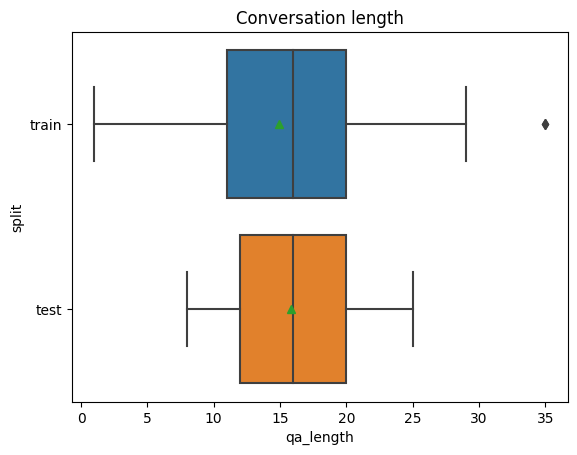

In [ ]:
display(df["qa_length"].describe())
plt.title("Conversation length")
sns.boxplot(data=df, x="qa_length", y="split", showmeans=True);

Here, we want to statistics about number of words/tokens.

In [ ]:
tokenizers_ = {
    k: AutoTokenizer.from_pretrained(checkpoint).tokenize
    for k, checkpoint in CONFIG.checkpoints.__dict__.items()
}
tokenizers = {"": str.split}
tokenizers.update(tokenizers_)

In [ ]:
def plot_length(dataset: pd.DataFrame,
                column: str,
                column_name: Optional[str] = None,
                split_fn=str.split,
                notes: Optional[str] = None,
                max_length=None):
    if column_name is None:
        column_name = column

    length_col = column_name + "_length"
    length = dataset[column].apply(split_fn).apply(len)
    dp = dataset[["split"]].copy()
    dp[length_col] = length

    if notes:
        print(notes)
    display(dp.groupby("split").describe())

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    boxplot = sns.boxplot(data=dp, x=length_col, y="split", showmeans=True, ax=axes[0])
    histplot = sns.histplot(dp,
                 x=length_col,
                 hue="split",
                 stat="density",
                 common_norm=False,
                 discrete=True,
                 ax=axes[1])
    if max_length is not None:
        boxplot.axvline(x=max_length, color='red', ls='--')
        histplot.axvline(x=max_length, color='red', ls='--')
    fig.suptitle(f"{column_name.capitalize()} length ({notes})", fontsize=16)
    plt.show()

passage_length                                                          
               count      mean        std    min     25%    50%    75%     max
split                                                                         
test           500.0  261.8220  71.018995  124.0  221.75  261.0  292.0   804.0
train         7193.0  271.0228  64.901153   70.0  245.00  266.0  293.0  1030.0

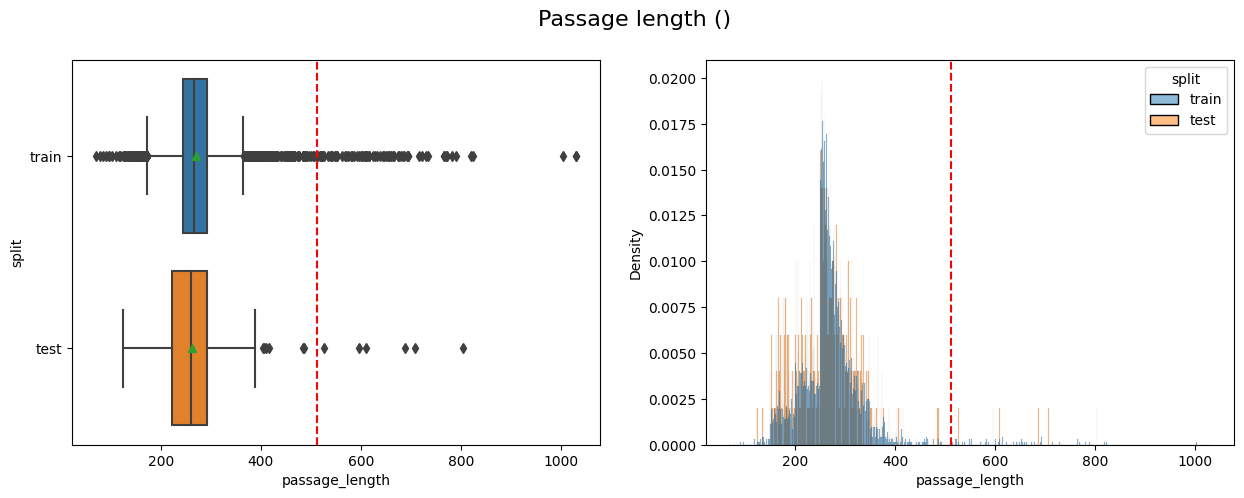

Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors


distil_roberta


passage_length                                                      
               count        mean        std    min    25%    50%    75%   
split                                                                     
test           500.0  345.926000  99.027458  148.0  283.0  352.5  399.0  \
train         7193.0  362.021271  89.147521   89.0  320.0  364.0  401.0   

               
          max  
split          
test   1045.0  
train  1375.0

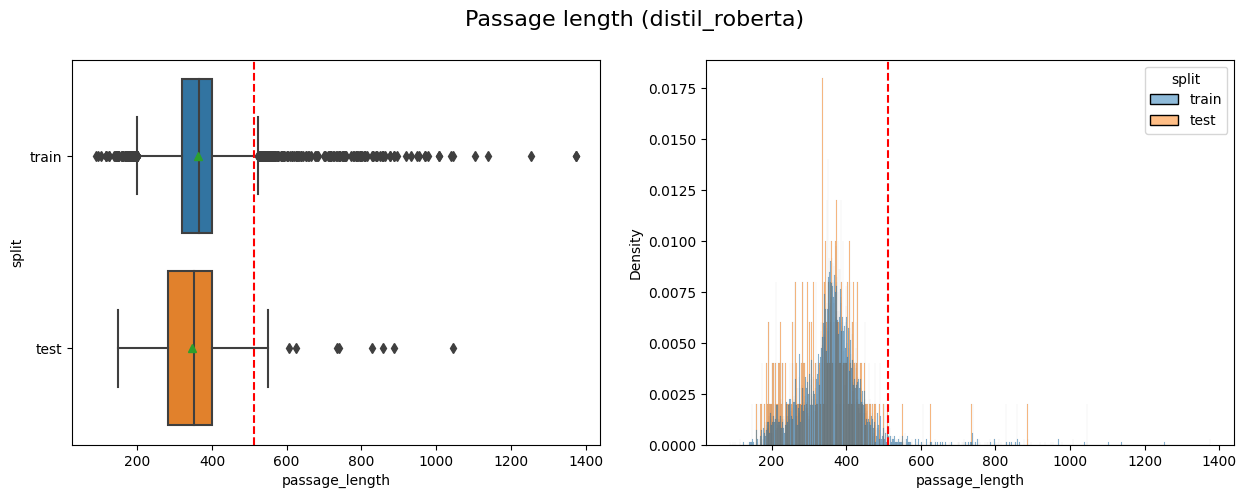

bert_tiny


passage_length                                                      
               count        mean        std    min    25%    50%    75%   
split                                                                     
test           500.0  336.386000  95.933244  149.0  275.5  342.0  382.0  \
train         7193.0  350.610455  85.863011   87.0  310.0  349.0  387.0   

               
          max  
split          
test   1036.0  
train  1322.0

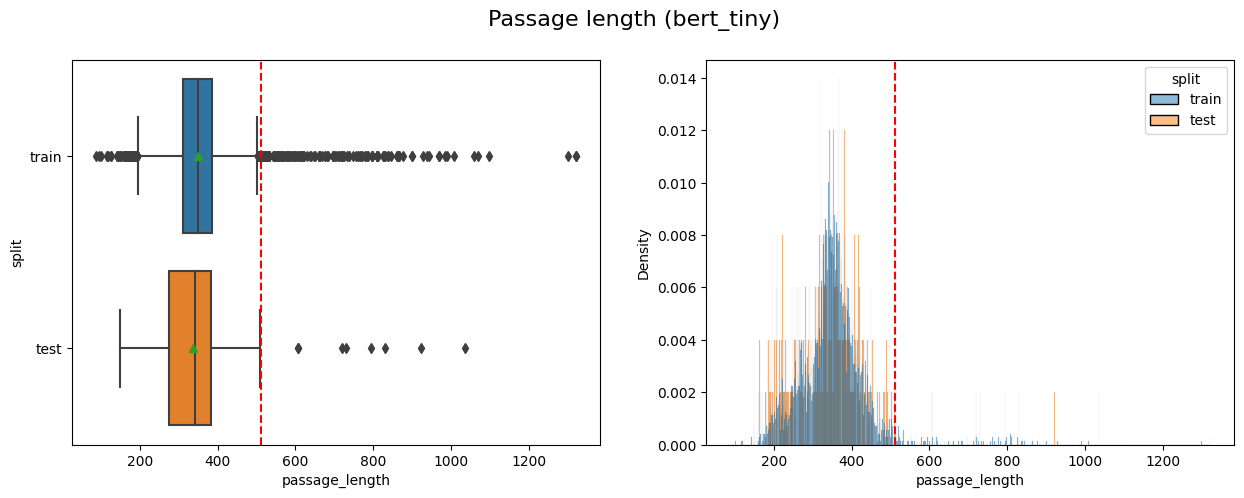

In [ ]:
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(df,
                column="story",
                column_name="passage",
                split_fn=tokenize_fn,
                notes=checkpoint_name,
                max_length=512)

To analyze questions, answers and rationales, let's explode them.

In [ ]:
qa_dataset = explode_qa(df)
assert not np.any(qa_dataset["answer_type"] == "unknown")
del df

question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  5.466279  2.458356  1.0  4.0  5.0  7.0  23.0
train        107286.0  5.457534  2.472842  1.0  4.0  5.0  7.0  42.0

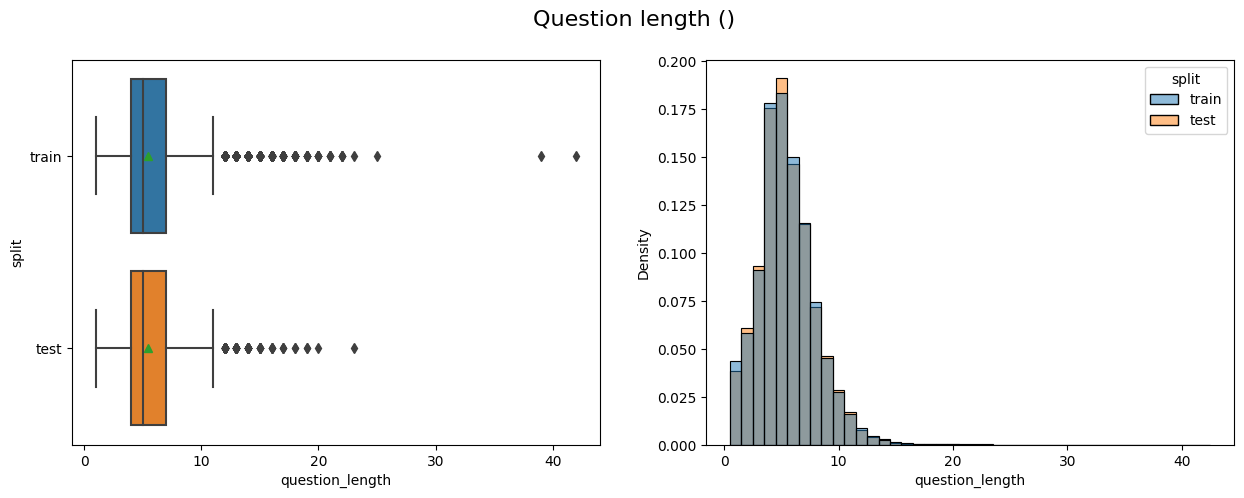

distil_roberta


question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  6.680349  2.663522  1.0  5.0  6.0  8.0  24.0
train        107286.0  6.709962  2.698654  1.0  5.0  6.0  8.0  51.0

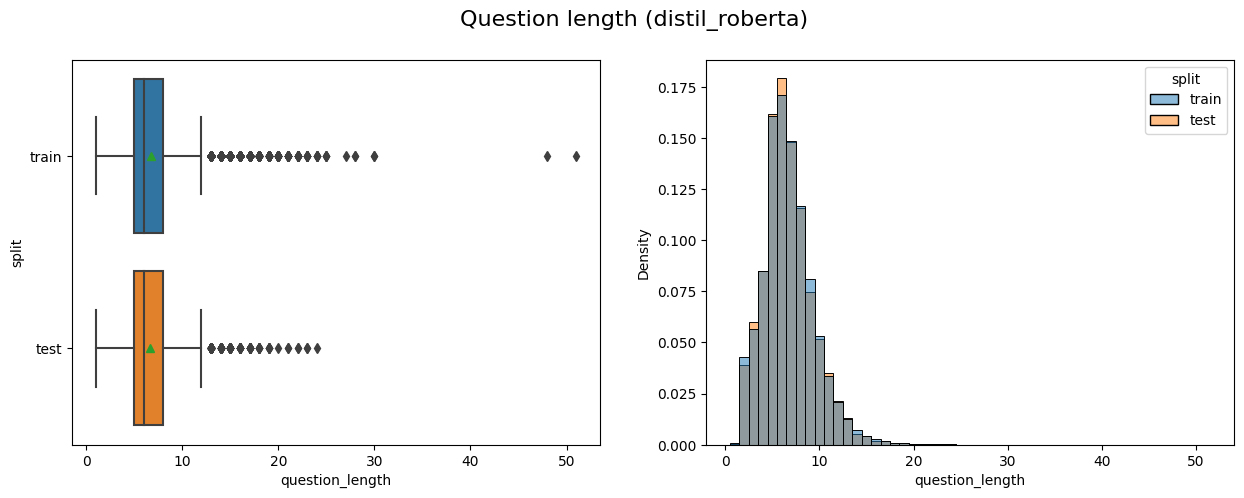

bert_tiny


question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  6.689189  2.686615  1.0  5.0  6.0  8.0  24.0
train        107286.0  6.718509  2.720698  1.0  5.0  6.0  8.0  51.0

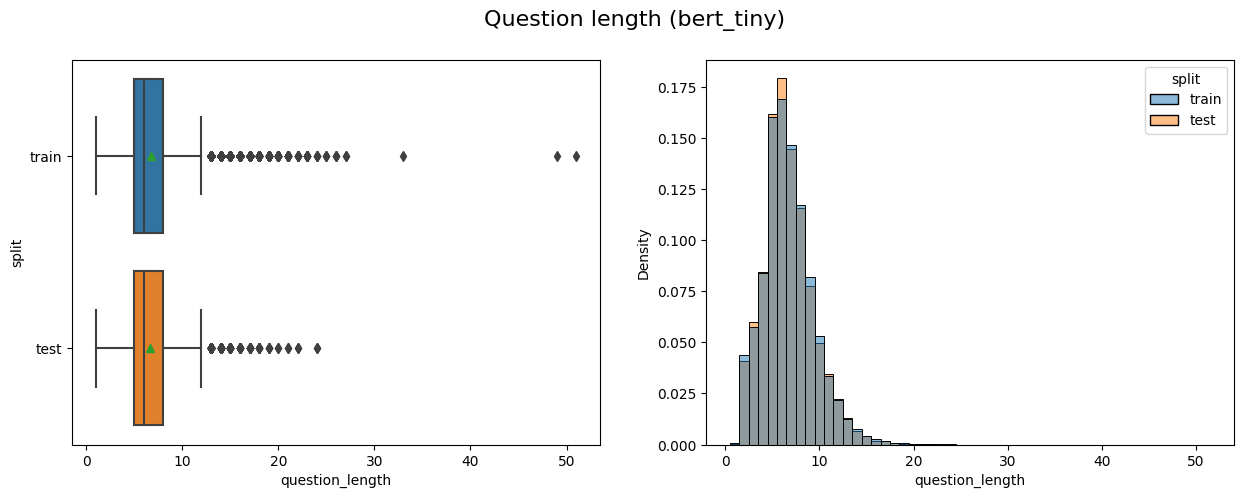

In [ ]:
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="question",
                split_fn=tokenize_fn,
                notes=checkpoint_name)

answer_length                                               
              count      mean       std  min  25%  50%  75%    max
split                                                             
test         7918.0  2.533973  2.280904  1.0  1.0  2.0  3.0   21.0
train      107286.0  2.674934  2.928911  1.0  1.0  2.0  3.0  353.0

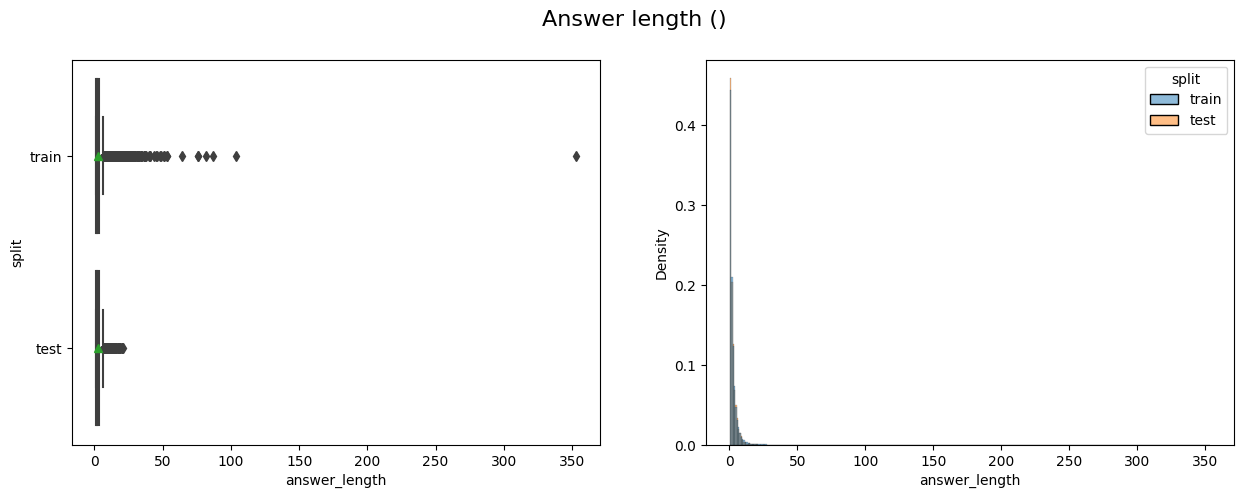

distil_roberta


answer_length                                               
              count      mean       std  min  25%  50%  75%    max
split                                                             
test         7918.0  3.382167  2.936393  1.0  1.0  3.0  4.0   44.0
train      107286.0  3.571137  3.681034  1.0  1.0  3.0  5.0  416.0

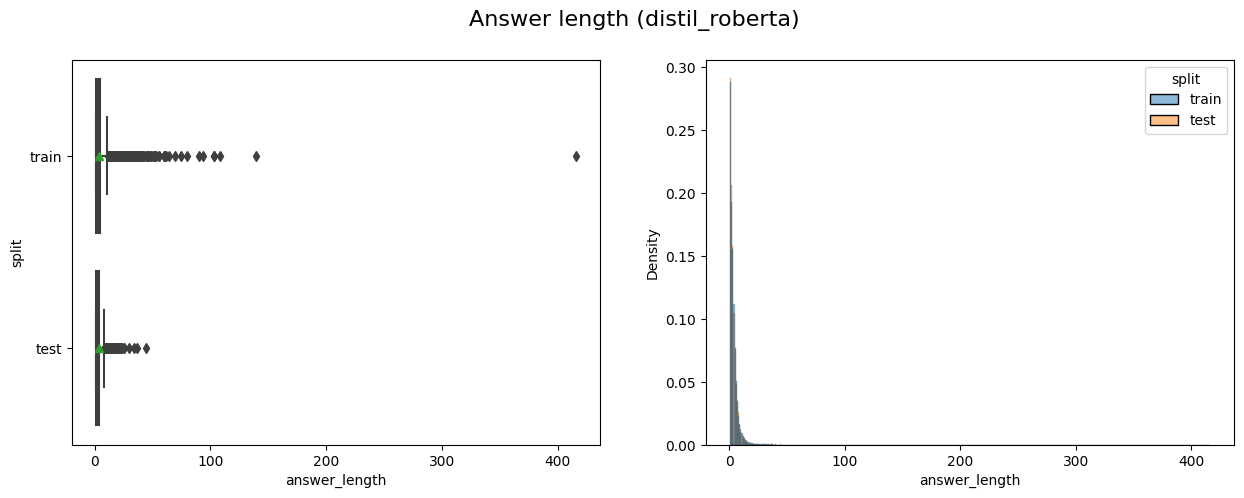

bert_tiny


answer_length                                               
              count      mean       std  min  25%  50%  75%    max
split                                                             
test         7918.0  3.160647  2.913724  1.0  1.0  2.0  4.0   34.0
train      107286.0  3.342337  3.696387  1.0  1.0  2.0  4.0  425.0

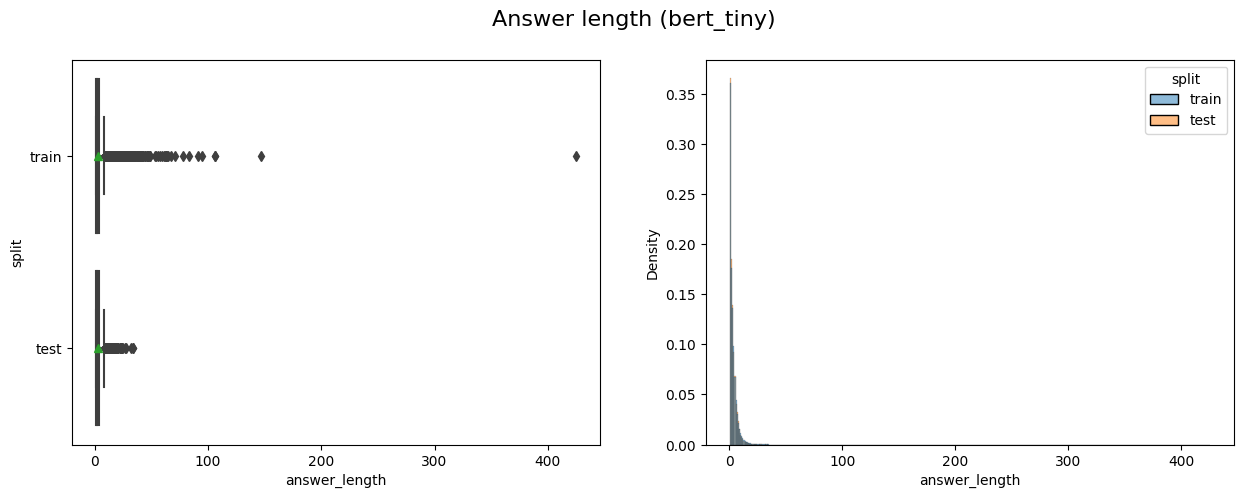

In [ ]:
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="answer",
                split_fn=tokenize_fn,
                notes=checkpoint_name)

There are some very long answers. It's likely most of them are trash and can be removed from the dataset.

Let's inspect the answer length per answer_type.

answer_length                                           
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.000000  0.000000  1.0  1.0  1.0  1.0  \
                train         946.0  1.003171  0.056254  1.0  1.0  1.0  1.0   
fluency         test         1003.0  4.393819  2.612621  1.0  2.0  4.0  6.0   
                train       13760.0  4.591715  3.158785  1.0  2.0  4.0  6.0   
multiple_choice test           33.0  1.090909  0.291937  1.0  1.0  1.0  1.0   
                train         262.0  1.175573  0.553372  1.0  1.0  1.0  1.0   
span            test         5192.0  2.682974  2.268704  1.0  1.0  2.0  3.0   
                train       71348.0  2.825153  3.061596  1.0  1.0  2.0  3.0   
yes_no          test         1619.0  1.000618  0.024853  1.0  1.0  1.0  1.0   
                train       20970.0  1.000238  0.015440  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     1.0  
                train    2.0  
fluency         test    20.0  
                train   64.0  
multiple_choice test     2.0  
                train    5.0  
span            test    21.0  
                train  353.0  
yes_no          test     2.0  
                train    2.0

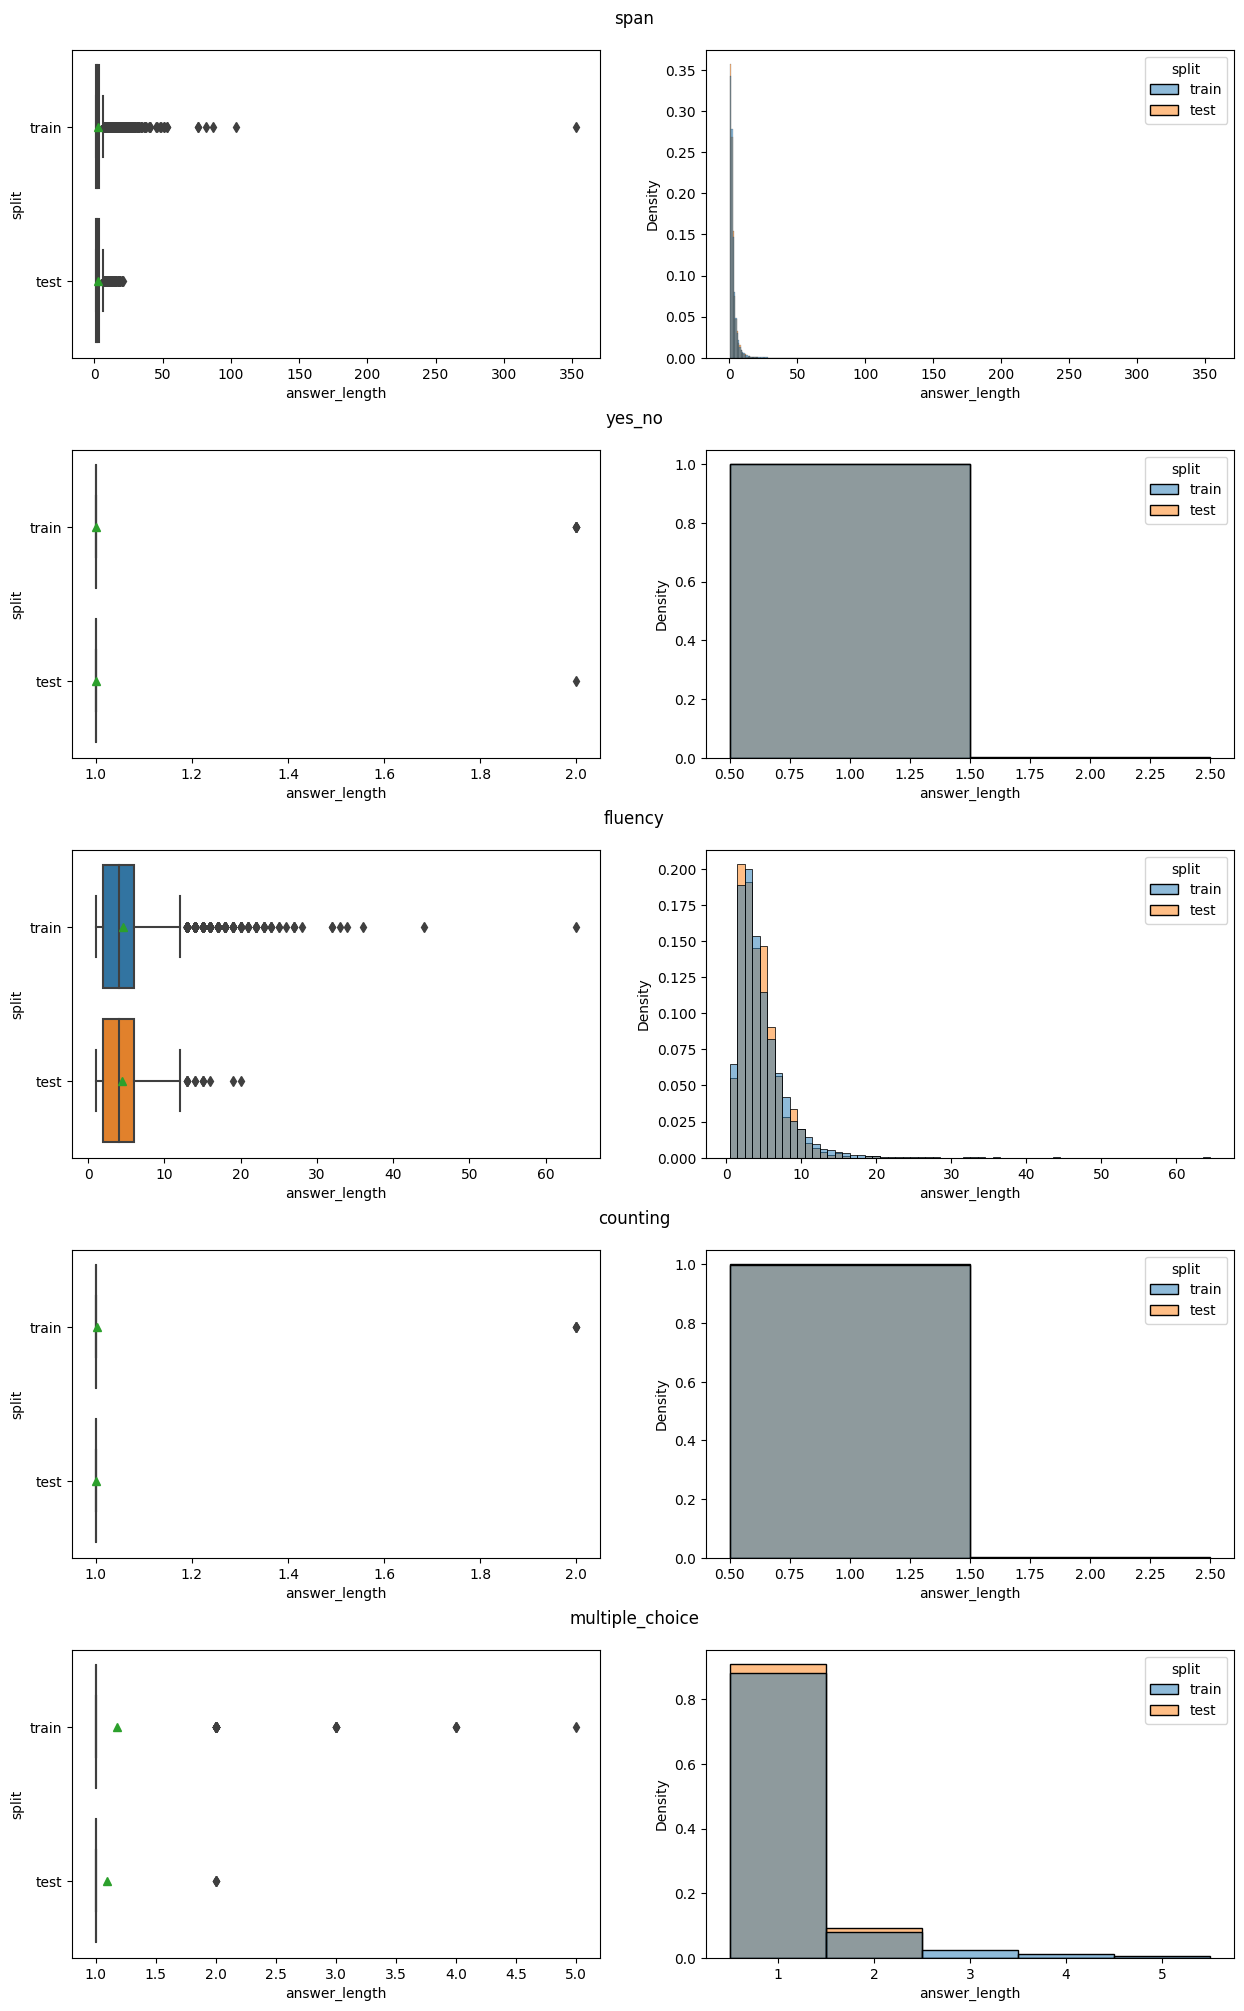

distil_roberta


answer_length                                           
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.112676  0.360527  1.0  1.0  1.0  1.0  \
                train         946.0  1.140592  0.608842  1.0  1.0  1.0  1.0   
fluency         test         1003.0  5.357926  3.104710  1.0  3.0  5.0  7.0   
                train       13760.0  5.630596  3.837298  1.0  3.0  5.0  7.0   
multiple_choice test           33.0  1.515152  0.712444  1.0  1.0  1.0  2.0   
                train         262.0  1.469466  0.756215  1.0  1.0  1.0  2.0   
span            test         5192.0  3.757704  2.938370  1.0  2.0  3.0  5.0   
                train       71348.0  3.947735  3.823792  1.0  2.0  3.0  5.0   
yes_no          test         1619.0  1.091414  0.290423  1.0  1.0  1.0  1.0   
                train       20970.0  1.074344  0.264689  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     3.0  
                train   11.0  
fluency         test    24.0  
                train   75.0  
multiple_choice test     3.0  
                train    6.0  
span            test    44.0  
                train  416.0  
yes_no          test     3.0  
                train    3.0

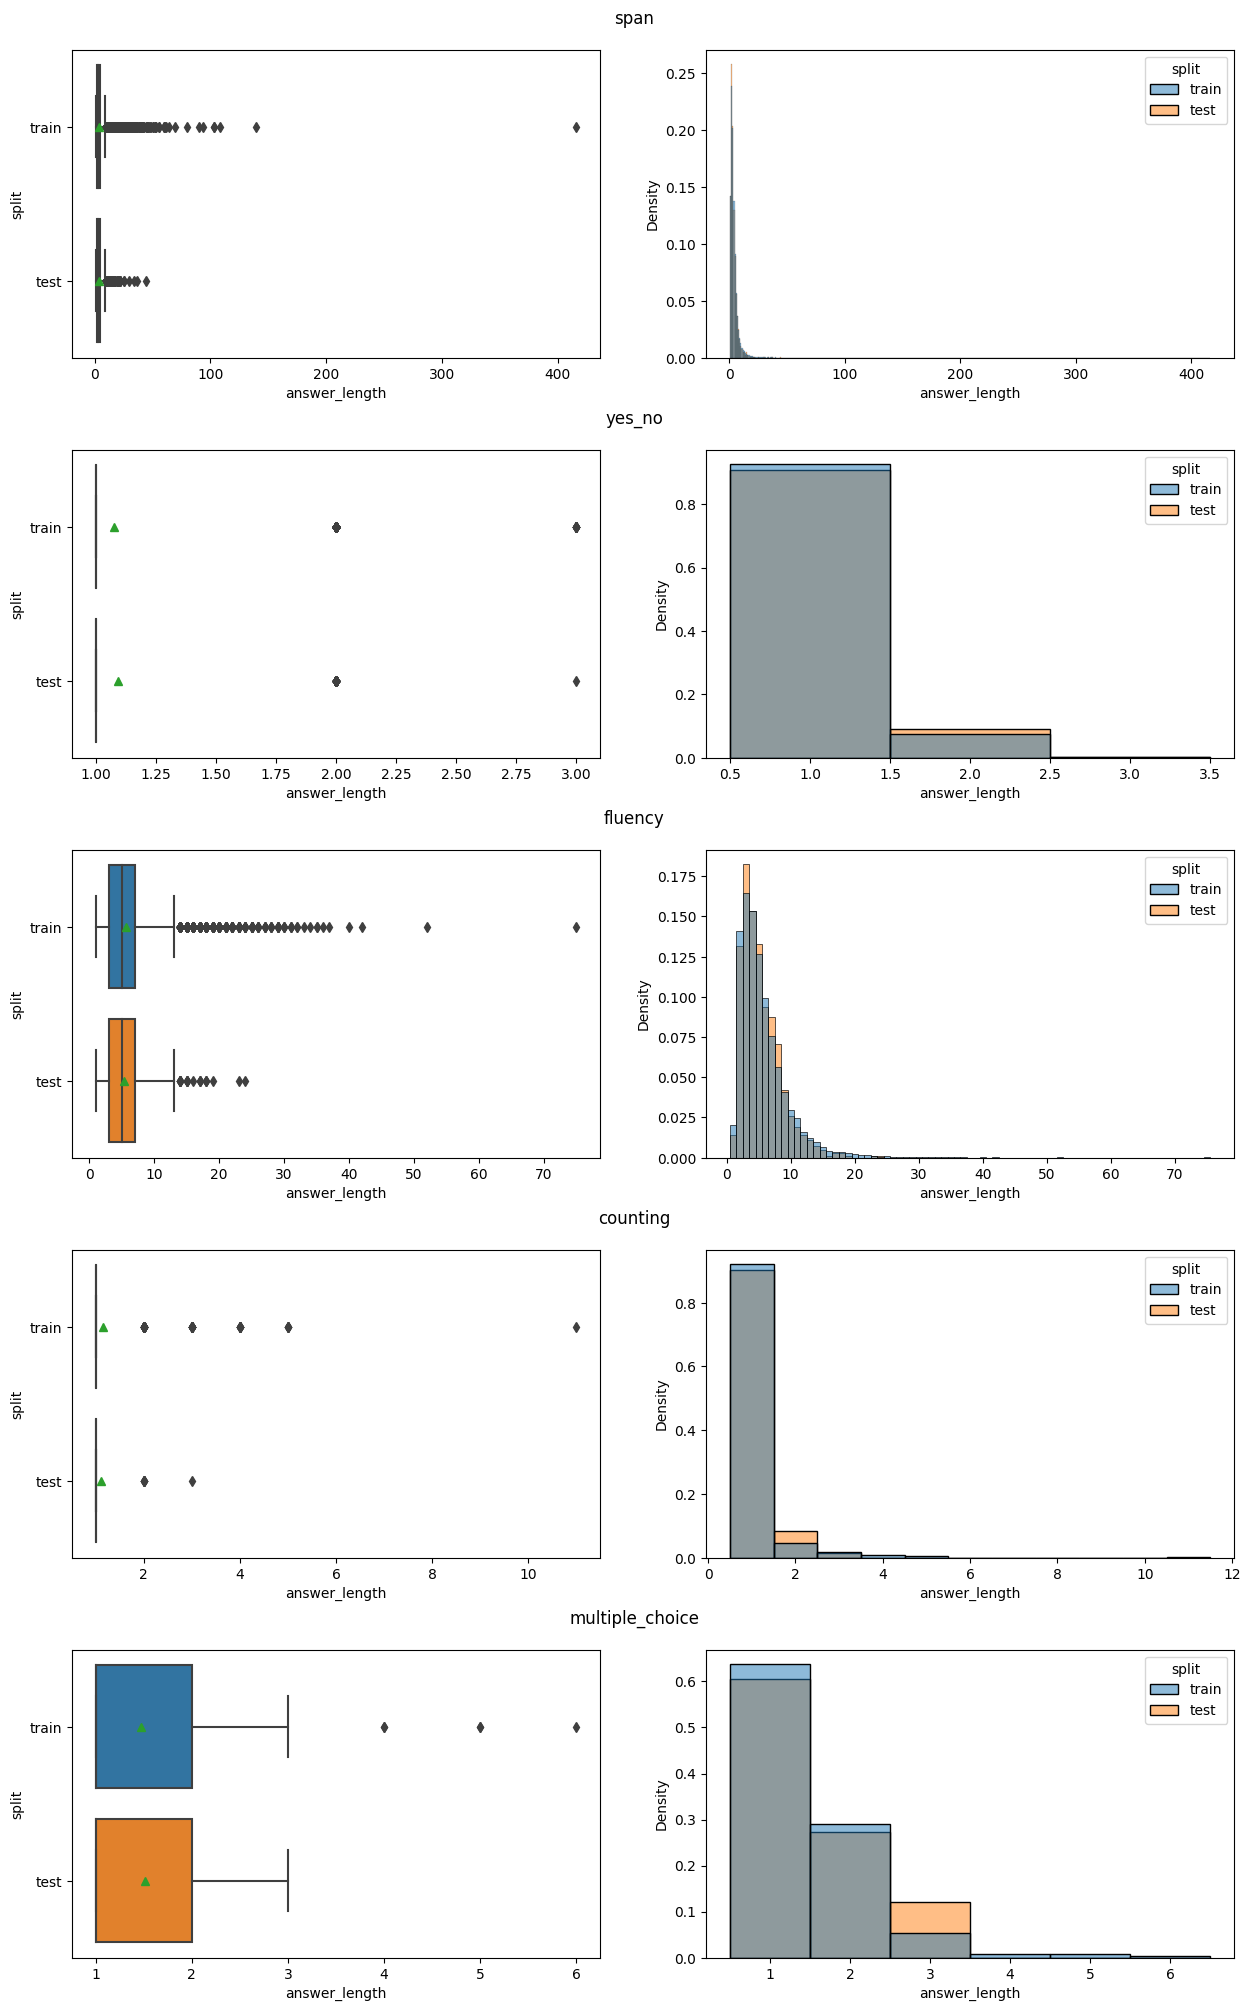

bert_tiny


answer_length                                           
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.112676  0.360527  1.0  1.0  1.0  1.0  \
                train         946.0  1.118393  0.558475  1.0  1.0  1.0  1.0   
fluency         test         1003.0  5.261216  3.174807  1.0  3.0  5.0  7.0   
                train       13760.0  5.508067  3.897807  1.0  3.0  5.0  7.0   
multiple_choice test           33.0  1.242424  0.501890  1.0  1.0  1.0  1.0   
                train         262.0  1.328244  0.742190  1.0  1.0  1.0  1.0   
span            test         5192.0  3.440485  2.936941  1.0  1.0  3.0  4.0   
                train       71348.0  3.628329  3.874219  1.0  2.0  3.0  4.0   
yes_no          test         1619.0  1.090797  0.287409  1.0  1.0  1.0  1.0   
                train       20970.0  1.073677  0.263251  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     3.0  
                train   11.0  
fluency         test    24.0  
                train   78.0  
multiple_choice test     3.0  
                train    7.0  
span            test    34.0  
                train  425.0  
yes_no          test     2.0  
                train    4.0

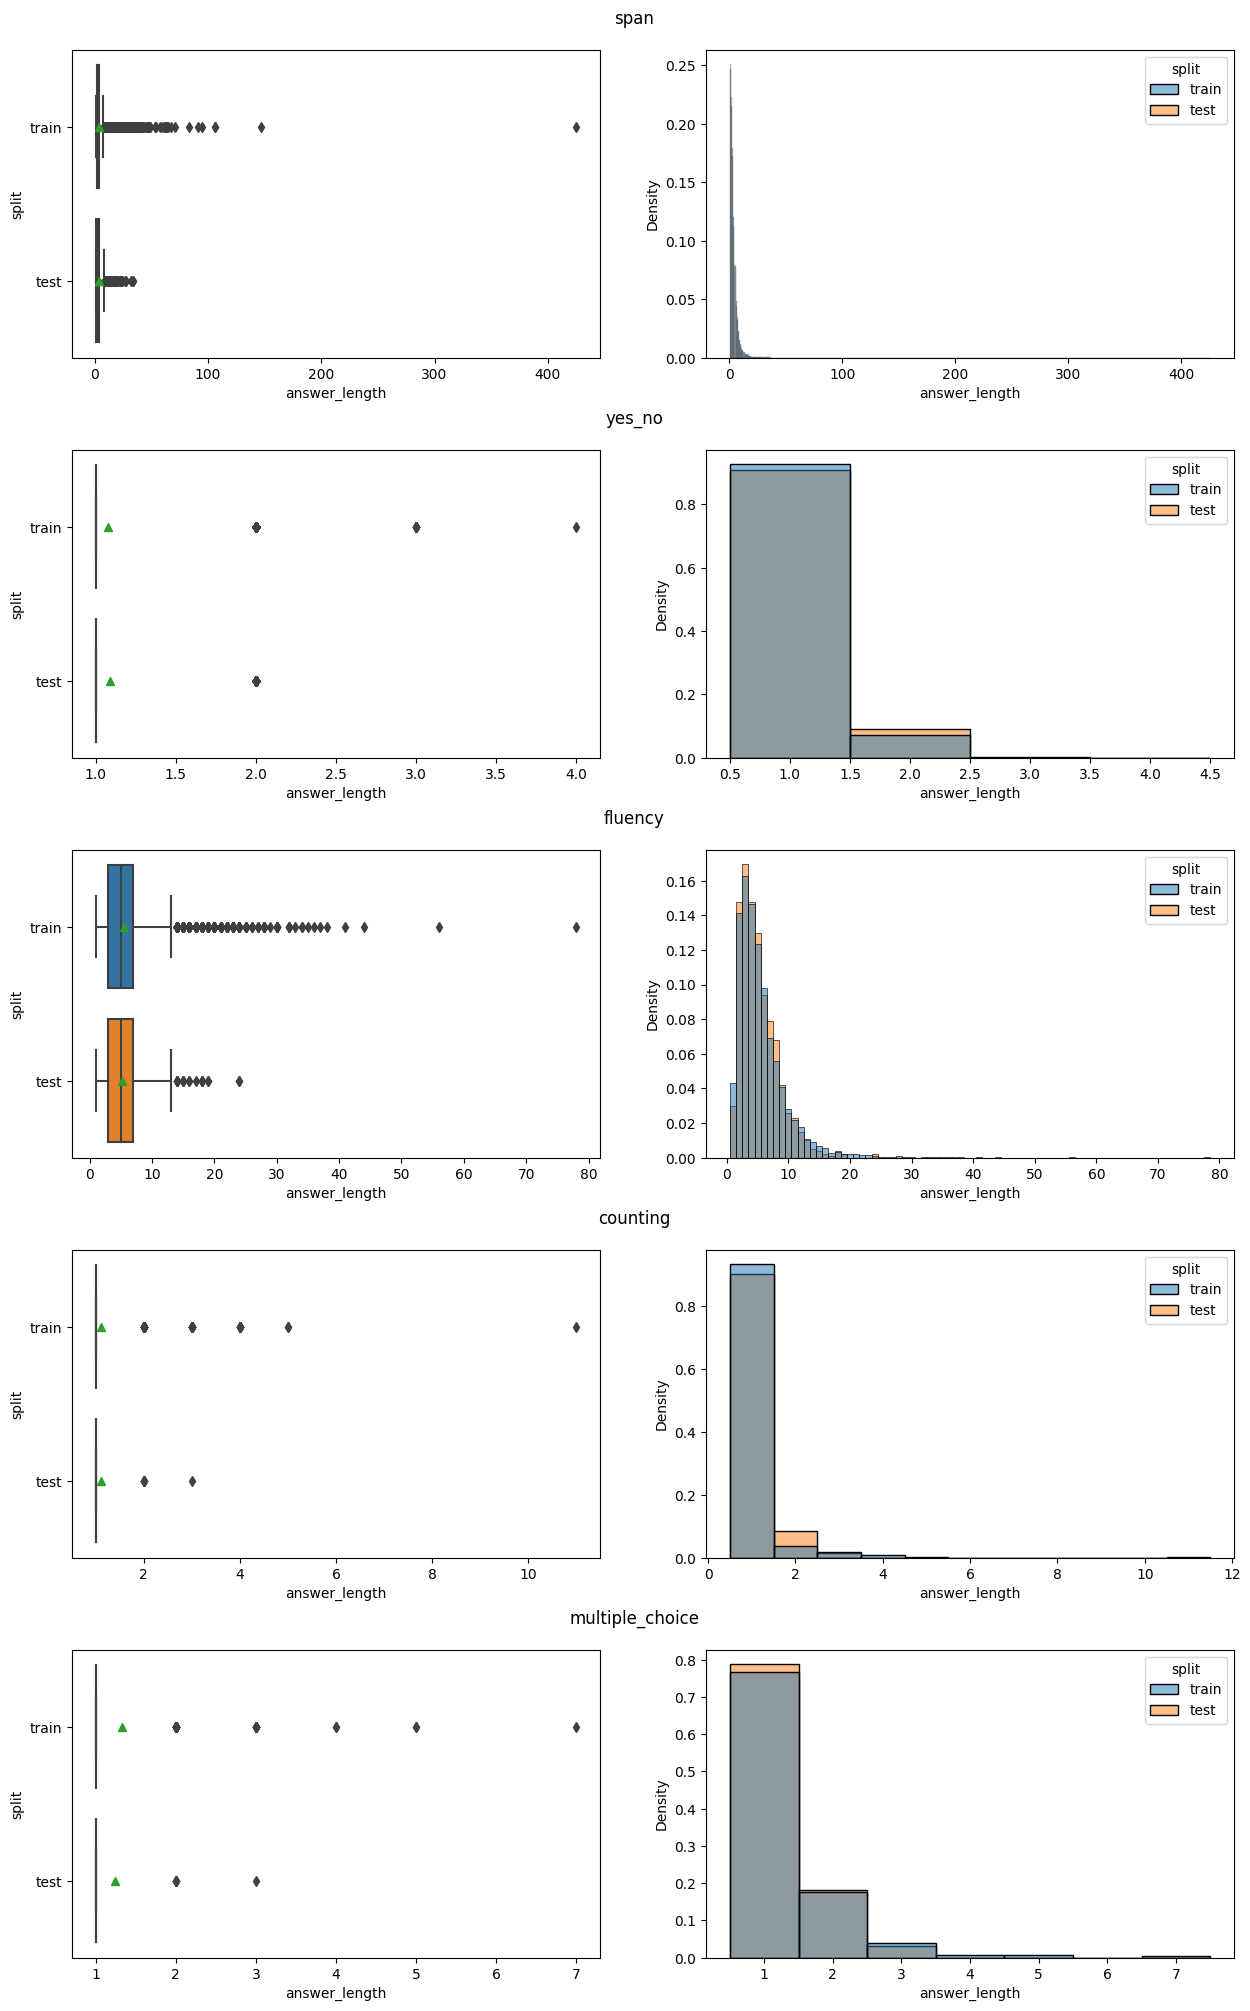

In [ ]:
def plot_answer_length(dataset, split_fn=str.split, notes=None):
    length_col = "answer" + "_length"
    length = dataset["answer"].apply(split_fn).apply(len)
    dp = dataset[["answer_type", "split"]].copy()
    dp[length_col] = length

    if notes:
        print(notes)
    display(dp.groupby(["answer_type", "split"]).describe())

    answer_types = AnswerType.list(return_unknown=False)
    fig = plt.figure(figsize=(15, 4 * len(answer_types)))
    fig.suptitle(f"Answer length ({notes})", fontsize=16)

    subfigs = fig.subfigures(nrows=len(answer_types), ncols=1)
    for answer_type, subfig in zip(answer_types, subfigs):
        data = dp[dp["answer_type"] == answer_type]
        subfig.suptitle(answer_type)
        axes = subfig.subplots(1, 2)
        sns.boxplot(data=data,
                    x=length_col,
                    y="split",
                    showmeans=True,
                    ax=axes[0])
        sns.histplot(data,
                     x=length_col,
                     hue="split",
                     stat="density",
                     common_norm=False,
                     discrete=True,
                     ax=axes[1])
    plt.show()
    
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_answer_length(qa_dataset, split_fn=tokenize_fn, notes=checkpoint_name)

It's likely that very long answers need to be cleaned or to be removed. Let's start with `SPAN` answers.

In [ ]:
def to_readable_question(question, answer, rationale, answer_type, turn=None):
    lines = []
    if turn is not None:
        lines.append(f'turn: {turn}')
    lines.append(f'Q\t\t{question} || {answer_type}')
    lines.append(f'A\t\t{answer} || {rationale}')

    return '\n'.join(lines)


def print_readable_questions(data: pd.DataFrame, show_turn=False):
    for _, row in data.iterrows():
        print("id:", row["id"])
        turn = row["turn"] if show_turn else None
        print(
            to_readable_question(row["question"],
                                 row["answer"],
                                 row["rationale"],
                                 row["answer_type"],
                                 turn=turn))
        print()

def show_long_answers(qa_dataset, answer_type, length):
    answers = qa_dataset[qa_dataset["answer_type"] == str(answer_type)].copy()
    answers["length"] = answers["answer"].str.split().apply(len)
    answers = answers.sort_values("length", ascending=False)
    long_answers = answers[answers["length"] > length]
    print(f"{answer_type} answers longer than {length} words:", len(long_answers))
    print_readable_questions(long_answers)

By manual inspection, we found that all the `span` answers longer than 37 words are useless, since they are just parts of the passage and do not answer their relative question.

In [ ]:
show_long_answers(qa_dataset, answer_type = AnswerType.SPAN, length = 37)

span answers longer than 37 words: 18
id: 3y5140z9dxgb0yn2jvyfav6mf1tipy
Q		The last? || span
A		At the age of sixteen, I went on my first volunteer program in West Virginia to repair or build homes for poor families. When we arrived, we discovered that the family we were going to help was living in a trailer that was in poor condition, no bigger than two parking spaces. A group of people had been working on it for two weeks, but every time they finished one problem, another appeared. We soon decided that the only way was to build a new house. It was something unusual because normally our goal was to repair old homes. The family was pleased with their new house that was 20 by 30 feet with three bedrooms, a bath and a kitchen. On Tuesday of that week, I asked the family's three boys, Josh, Eric and Ryan, "What do you want for your new room?" Kids in the families we had helped usually wanted toys or posters, so we were surprised when Josh, the oldest boy said, "We just want beds." The bo

`Yes_no` answers with more than 1 words need to be cleaned.

In [ ]:
show_long_answers(qa_dataset, answer_type = AnswerType.YES_NO, length = 1)

yes_no answers longer than 1 words: 6
id: 3i02618ya06g9pi2dcnttyux9jnupz
Q		Do they have a radio station? || yes_no
A		Yes :) || radio and television station

id: 3u5jl4wy5k9m10qekx6sa7i6ce3x4g
Q		Was Mrs Todgers a fancy dressing woman? || yes_no
A		. No. || . M. Todgers looked a little worn by cares of gravy and other such solicitudes arising out of her establishment, but displayed her usual earnestness and warmth of manner. 


id: 3ps7w85z8z2ghpn6wi1m2c8glett9x
Q		Did she visit other kids? || yes_no
A		. yes || . After that, she visited the hospital many times. Every time she visited, she brought toy bears

id: 3jcg6dtrv3q9h8c0wgidj2niarzqq6
Q		All of his life? || yes_no
A		. no || . Thurmond joined the Republican Party in the 1960s and ultimately turned away from his segregationist past. 

id: 3o7l7bfshep737ycahi4gj7i1qleiv
Q		Does everyone agree with the standard? || yes_no
A		. no || . Although not universally accepted, since then 

id: 3nkqq8o39y57ksfc83wyt4d8va6dua
Q		Was she ri

`Counting` answers with two words are ok. The examples below show also that some of the answers annotated as `counting` are rather `fluency`.

In [ ]:
show_long_answers(qa_dataset, answer_type = AnswerType.COUNTING, length = 1)

counting answers longer than 1 words: 3
id: 3jwh6j9i9sd1a5xjx6t6kjxekp0nbc
Q		How old was he? || counting
A		Twenty Seven || age of 27

id: 37fmassaycr9w4ms0qgefb1xykpiby
Q		How many petty princely states were absorbed into Himachal? || counting
A		Twenty eight || 15 April 1948 as a result of integration of 28 petty princely states

id: 3jwh6j9i9sd1a5xjx6t6kjxekp0nbc
Q		How many internationals goals did he have? || counting
A		Twenty Four ||  24 international goals 



Also `multiple_choice` answers with more than 1 word are ok.

In [ ]:
show_long_answers(qa_dataset, answer_type = AnswerType.MULTIPLE_CHOICE, length = 1)

multiple_choice answers longer than 1 words: 34
id: 3lpw2n6lkt2cgf0jtxefvspgiwju50
Q		Did Sarah right about her and her brother's experience or some other people's? || multiple_choice
A		About her and her brother's ||  Sarah has now written a best-selling book about their experience, calledAnyone Can Do It ! 

id: 3olf68ytn91k33fat4axh34z0jjfay
Q		Does the program air at the end of the week or the front of the week? || multiple_choice
A		front of the week || Monday night

id: 3m0nz3jdp1yt2eutzkdnck4vjx95zc
Q		did it take her longer to hike up alone or down with the dog? || multiple_choice
A		Down with the dog. || The trip up had taken 30 minutes while going back down took twice that.

id: 3k3r2qnk8b3vh22vwnrw78ui4spu9e
Q		was instructed to go, or told to think about it? || multiple_choice
A		To think about it. ||  I know she said that she would sooner that you were present than all her English friends together. However, you can think about it.

id: 340ugxu9dy1te9fyzowszqjfvk3vuq
Q		Was

Let's inspect the question-passage length, i.e. the input length when there is no history.

question-passage_length                                               
                        count        mean        std    min    25%    50%   
split                                                                       
test                   7918.0  270.235034  72.681189  125.0  231.0  267.0  \
train                107286.0  276.325905  63.047269   72.0  252.0  272.0   

                      
         75%     max  
split                 
test   299.0   812.0  
train  299.0  1042.0

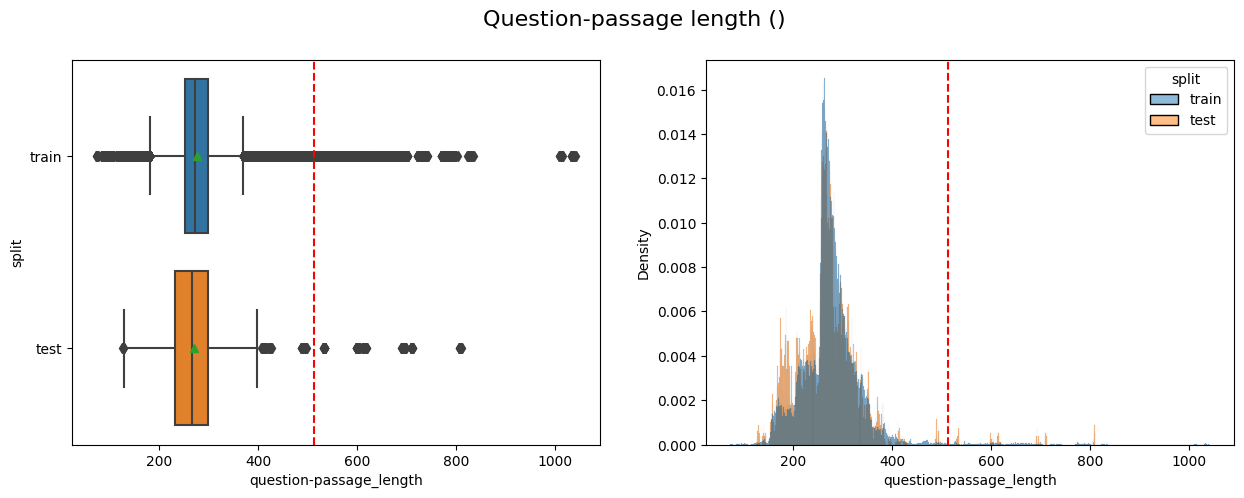

distil_roberta


question-passage_length                                                
                        count        mean         std    min    25%    50%   
split                                                                        
test                   7918.0  356.997853  100.797187  149.0  294.0  362.0  \
train                107286.0  368.918666   86.822364   94.0  329.0  371.0   

                      
         75%     max  
split                 
test   407.0  1055.0  
train  408.0  1386.0

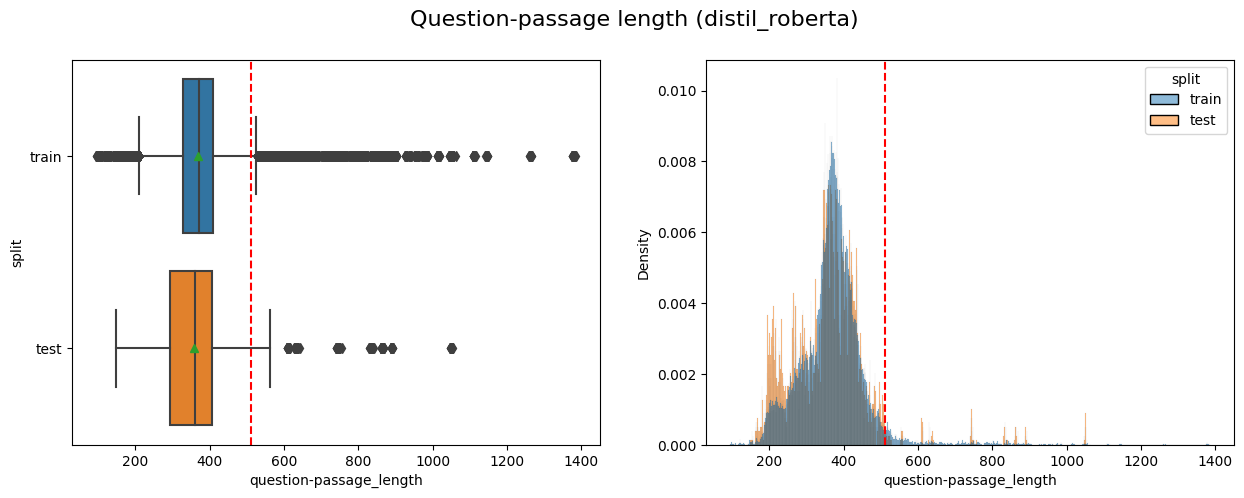

bert_tiny


question-passage_length                                               
                        count        mean        std    min    25%    50%   
split                                                                       
test                   7918.0  346.882925  97.682956  151.0  289.0  349.0  \
train                107286.0  357.272580  83.424987   92.0  318.0  356.0   

                      
         75%     max  
split                 
test   390.0  1047.0  
train  393.0  1335.0

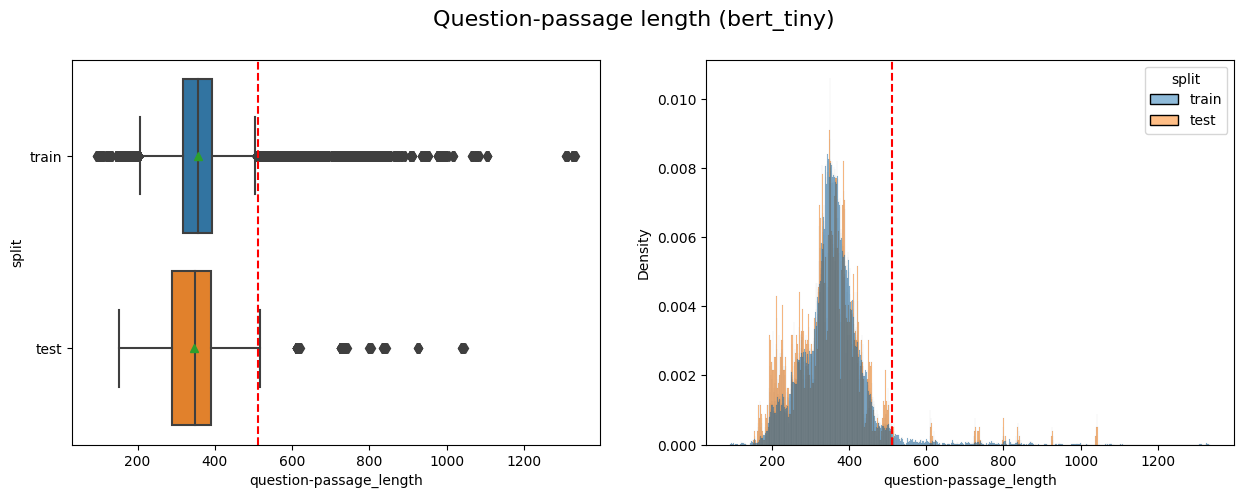

In [ ]:
qa_dataset["input"] = qa_dataset["question"] + " " + qa_dataset["story"]
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="input",
                column_name="question-passage",
                split_fn=tokenize_fn,
                notes=checkpoint_name,
                max_length=512)

Let's analyze the question-answer pair lengths, useful to have information on the history length.

question-answer pair_length                                            
                            count      mean       std  min  25%  50%   75%   
split                                                                        
test                       7918.0  8.000253  3.283074  2.0  6.0  7.0  10.0  \
train                    107286.0  8.132468  3.781931  2.0  6.0  7.0  10.0   

              
         max  
split         
test    28.0  
train  355.0

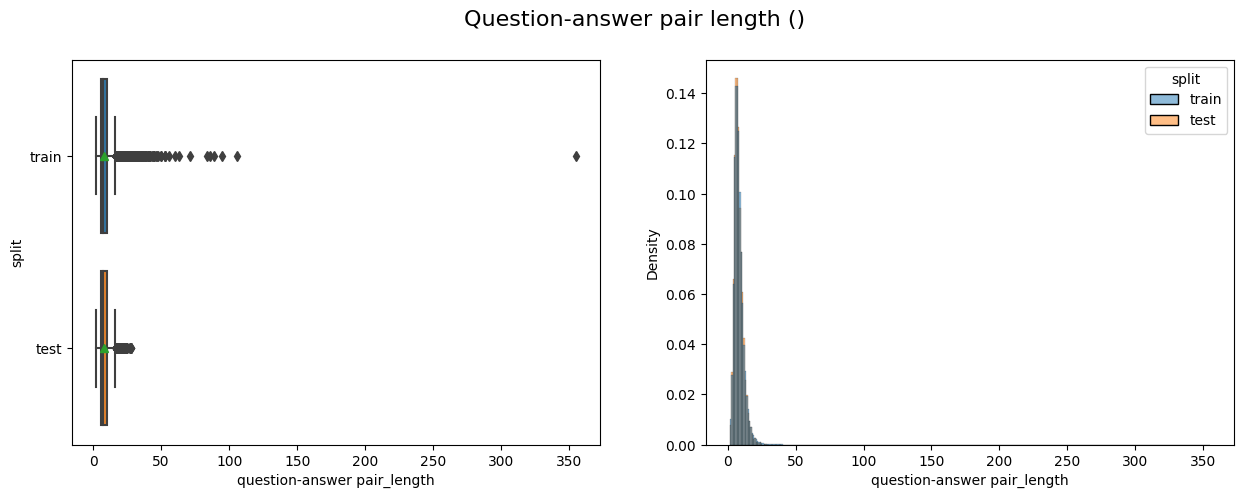

distil_roberta


question-answer pair_length                                             
                            count       mean       std  min  25%  50%   75%   
split                                                                         
test                       7918.0   9.881662  3.888559  2.0  7.0  9.0  12.0  \
train                    107286.0  10.092426  4.502837  2.0  7.0  9.0  12.0   

              
         max  
split         
test    49.0  
train  419.0

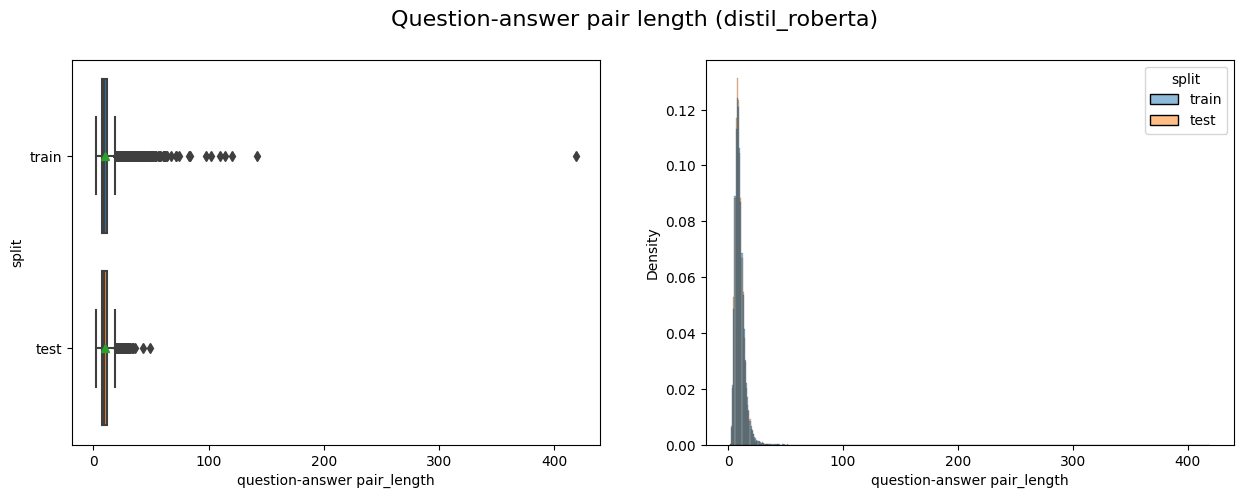

bert_tiny


question-answer pair_length                                             
                            count       mean       std  min  25%  50%   75%   
split                                                                         
test                       7918.0   9.849836  3.903834  2.0  7.0  9.0  12.0  \
train                    107286.0  10.060847  4.540767  2.0  7.0  9.0  12.0   

              
         max  
split         
test    40.0  
train  428.0

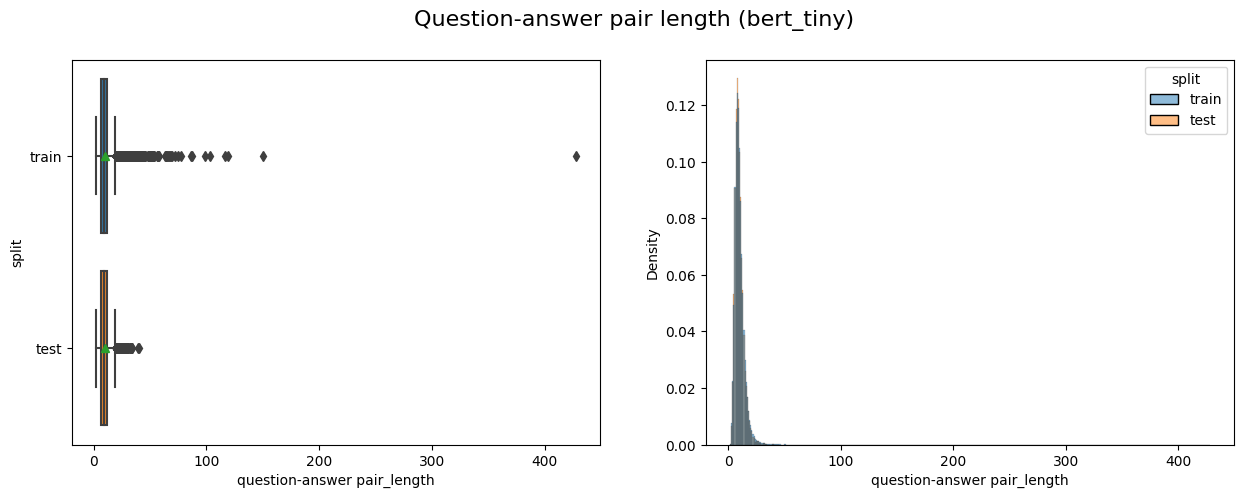

In [ ]:
qa_dataset["qa"] = qa_dataset["question"] + " " + qa_dataset["answer"]
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="qa",
                column_name="question-answer pair",
                split_fn=tokenize_fn,
                notes=checkpoint_name)

rationale_length                                                
                 count      mean       std  min  25%  50%   75%    max
split                                                                 
test            7918.0  9.133114  8.820682  1.0  4.0  7.0  12.0  268.0
train         107286.0  9.241252  9.257729  1.0  4.0  7.0  12.0  353.0

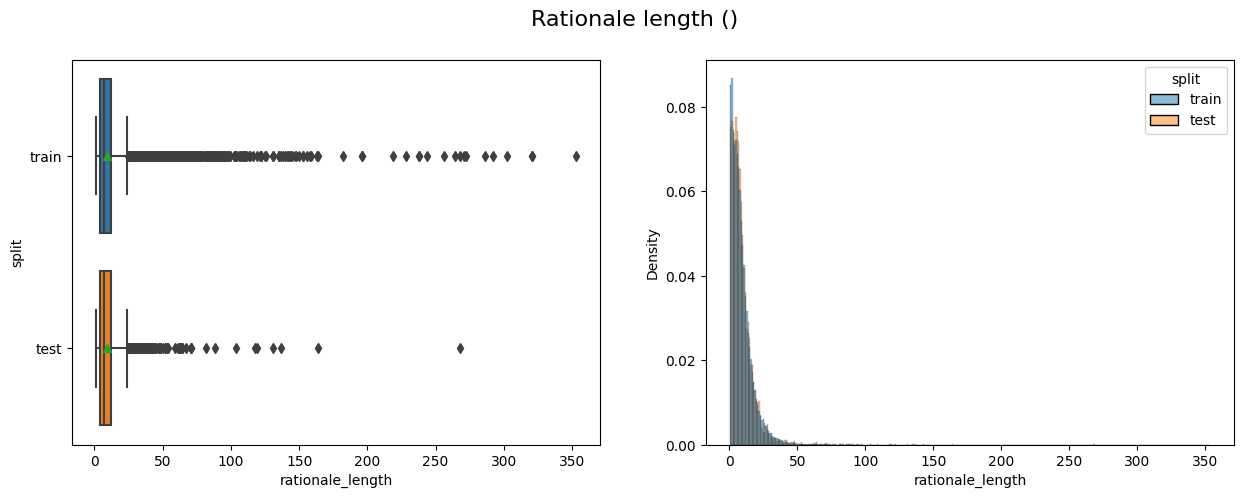

distil_roberta


rationale_length                                                  
                 count       mean        std  min  25%  50%   75%    max
split                                                                   
test            7918.0  11.755620  11.689437  1.0  5.0  9.0  15.0  414.0
train         107286.0  12.007997  12.147238  1.0  5.0  9.0  15.0  461.0

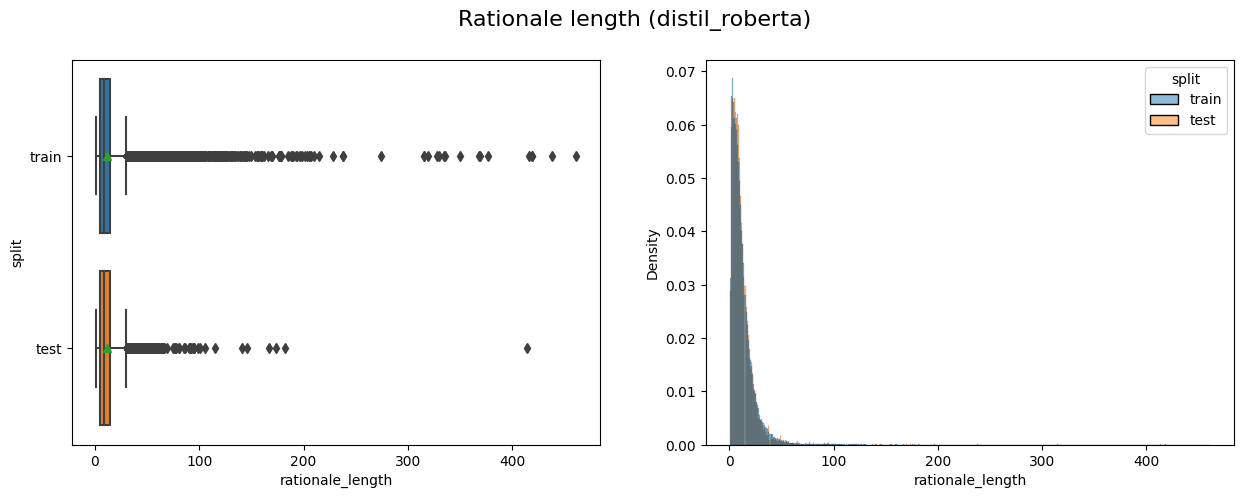

bert_tiny


rationale_length                                                  
                 count       mean        std  min  25%  50%   75%    max
split                                                                   
test            7918.0  11.437737  11.621558  1.0  5.0  9.0  15.0  402.0
train         107286.0  11.663283  12.094999  1.0  4.0  9.0  15.0  436.0

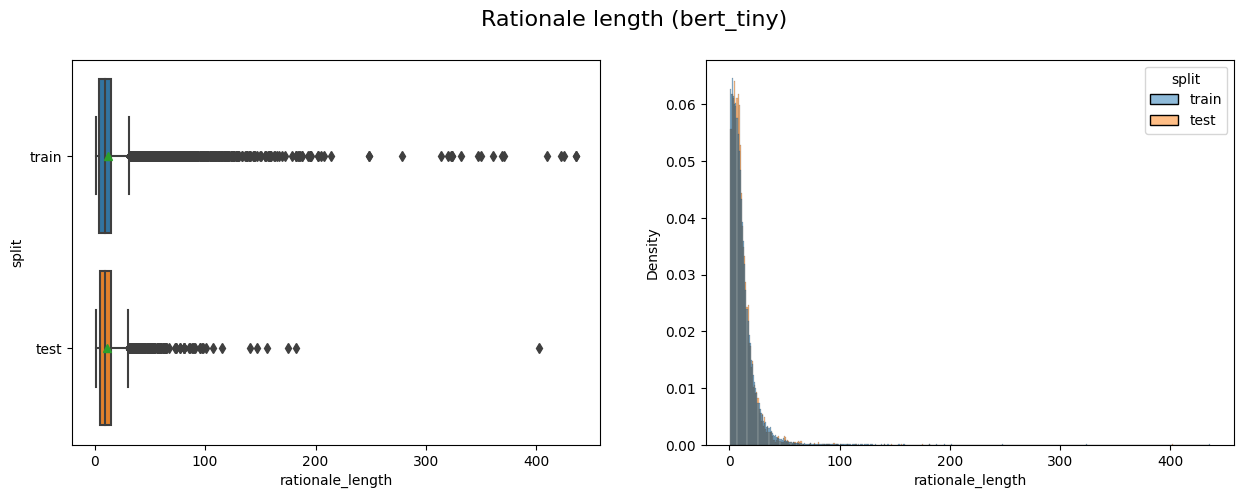

In [ ]:
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="rationale",
                split_fn=tokenize_fn,
                notes=checkpoint_name)

Most of the very lengthy rationales are a consequence of poor workmanship.

In [ ]:
def show_long_rationales(qa_dataset, length):
    rationales = qa_dataset.copy()
    rationales["length"] = rationales["rationale"].str.split().apply(len)
    rationales = rationales.sort_values("length", ascending=False)
    long_rationales = rationales[rationales["length"] > length]
    print("Number of questions with very long rationale:", len(long_rationales))
    print()
    print_readable_questions(long_rationales)
    
show_long_rationales(qa_dataset, length=150)

Number of questions with very long rationale: 28

id: 3y5140z9dxgb0yn2jvyfav6mf1tipy
Q		The last? || span
A		At the age of sixteen, I went on my first volunteer program in West Virginia to repair or build homes for poor families. When we arrived, we discovered that the family we were going to help was living in a trailer that was in poor condition, no bigger than two parking spaces. A group of people had been working on it for two weeks, but every time they finished one problem, another appeared. We soon decided that the only way was to build a new house. It was something unusual because normally our goal was to repair old homes. The family was pleased with their new house that was 20 by 30 feet with three bedrooms, a bath and a kitchen. On Tuesday of that week, I asked the family's three boys, Josh, Eric and Ryan, "What do you want for your new room?" Kids in the families we had helped usually wanted toys or posters, so we were surprised when Josh, the oldest boy said, "We just want b

In [ ]:
example = qa_dataset[qa_dataset["rationale"] == qa_dataset["story"]]
print("Number of questions with rationale equal to the whole passage:",
      len(example))
print()
print_readable_questions(example)

Number of questions with rationale equal to the whole passage: 11

id: 3vj40nv2qinjocrcy7k4z235f4yot6
Q		DId someone want to put olives on it? || yes_no
A		No. || The children's father wanted to know what every one wanted on their pizza. Andy wanted a strawberry on his pizza. Father thought that was funny. Father asked if anyone wanted chicken on the pizza. Sue did not want chicken. Andy wanted chicken. Dan did not want chicken, but their father wanted to get chicken on the pizza. Dan asked if they could have mushrooms on the pizza. Father did not like mushrooms. Andy and Sue wanted to have mushrooms, so their father had them put mushrooms on the pizza. Sue wanted to have green onions on the pizza. Father also wanted green onions. Dan and Andy did not like green onions, so they did not get green onions on the pizza. Father wanted to order thin crust pizza. Dan thought that thin crust pizza had the taste of an old shoe. Sue thought Dan was wrong. Sue wanted thin crust pizza also. Andy w

Upon further analysis of the corpus, we observed instances where words at the beginning or at the end of the rationale are truncated. Therefore, we have to fix them if we intend to use the rationale to train the network.

In [ ]:
def print_rationales(data: pd.DataFrame):
    for i, row in data.iterrows():
        print("id:", row["id"], "split:", row["split"])
        print("turn:", row["turn"])
        print("R:", row["rationale"], "|", row["span_start"], "-",
              row["span_end"])
        print("=" * 100)


def is_rationale_truncated(passage, span_start, span_end):
    if span_start > 0 and passage[span_start].isalnum() and passage[
            span_start - 1].isalnum():
        return True

    if span_end < len(passage) and passage[
            span_end - 1].isalnum() and passage[span_end].isalnum():
        return True

    return False


example = qa_dataset[qa_dataset.apply(lambda row: is_rationale_truncated(
    row["story"], row["span_start"], row["span_end"]),
                                      axis=1)]
print("Number of rationales with errors:", len(example), "/", len(qa_dataset))
print()
print_rationales(example)

Number of rationales with errors: 5572 / 115204

id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 2
R: he Vatican Library is a research library | 454 - 494
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 6
R: Scholars have traditionally divided the history of the library into five period | 1048 - 1127
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 11
R: atican Secret Archives were separated from the library at the beginning of the 17th century; | 917 - 1009
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 16
R: hotocopies for private study of pages from books published between 1801 and 1990 | 644 - 724
id: 3bdcf01ogxu7zdn9vlrbf2rqzwplyf split: train
turn: 11
R: the need of a helper, of a friend, of a champio | 751 - 798
id: 3urfvvm165iantk80llvkwwbjs7uzh split: train
turn: 3
R:  Valentina was very pale, and round her eyes there were dark circles that told of sleeplessness, and as she bowed her head in prayer, her ladies observed that tears were falling on the ill

In order to solve the issue, we have to:
1. remove any leading or trailing non alphanumeric character (i.e. spaces, punctuation, etc.) from the rationale.
2. compute new `span_start` and `span_end` indices by considering the entire words.

In [ ]:
#1. removing leading and trailing non alphanumeric chars
example = " Despite a common background, the groups' views on religious toleration were mixe."
print("Before:", example)
print("After:", strip_non_alphanumeric_chars(example))

Before:  Despite a common background, the groups' views on religious toleration were mixe.
After: Despite a common background, the groups' views on religious toleration were mixe


In [ ]:
qa_dataset_fixed = qa_dataset.copy()
qa_dataset_fixed["rationale"] = qa_dataset_fixed["rationale"].apply(
    strip_non_alphanumeric_chars)
n_affected_rationales = np.count_nonzero(
    qa_dataset_fixed["rationale"] != qa_dataset["rationale"])
print("Number of affected rationales:", n_affected_rationales, "/",
      len(qa_dataset))


Number of affected rationales: 55649 / 115204


In [ ]:
#2. compute span_start and span_end indices by considering the entire words.
passage = "\tThe Vatican Library is a research library for history, law, philosophy, science and theology."
rationale = "e Vatican Library is a research lib"
span_start, span_end = find_span(passage, rationale)
fixed_rationale = passage[span_start:span_end]
assert fixed_rationale == "The Vatican Library is a research library"

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)

print()

passage = " Mandi Marie Utash posted Friday to a GoFundMe.com page [...]\nMandi Marie Utash\twrote that her father doesn't seem to know what happened"
rationale = "andi Marie Utas"
span_start, span_end = find_span(passage,
                                 rationale,
                                 span_start=63,
                                 span_end=78)
fixed_rationale = passage[span_start:span_end]
assert fixed_rationale == "Mandi Marie Utash"

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)

P: 	The Vatican Library is a research library for history, law, philosophy, science and theology.
R (-): e Vatican Library is a research lib
R (+): The Vatican Library is a research library | 1 - 42

P:  Mandi Marie Utash posted Friday to a GoFundMe.com page [...]
Mandi Marie Utash	wrote that her father doesn't seem to know what happened
R (-): andi Marie Utas
R (+): Mandi Marie Utash | 62 - 79


In [ ]:
# Fix rationale by applying (1) and (2)
passage = "\tThe Vatican Library is a research library for history, law, philosophy, science and theology."
rationale = " e Vatican Library is a research library for history,  "
fixed_rationale, span_start, span_end = fix_rationale(passage, rationale, 1,
                                                      100)

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)
assert fixed_rationale == "The Vatican Library is a research library for history"

P: 	The Vatican Library is a research library for history, law, philosophy, science and theology.
R (-):  e Vatican Library is a research library for history,  
R (+): The Vatican Library is a research library for history | 1 - 54


In [ ]:
def _fix_rationale(row):
    fixed_rationale, span_start, span_end = fix_rationale(
        row["story"], row["rationale"], row["span_start"], row["span_end"])

    row["rationale"] = fixed_rationale
    row["span_start"] = span_start
    row["span_end"] = span_end

    return row


qa_dataset_fixed = qa_dataset.apply(_fix_rationale, axis=1)
diff_start = qa_dataset_fixed["span_start"] != qa_dataset["span_start"]
diff_end = qa_dataset_fixed["span_end"] != qa_dataset["span_end"]
diff_rationale = qa_dataset_fixed["rationale"] != qa_dataset["rationale"]

assert np.all((diff_start | diff_end) == diff_rationale)

example = qa_dataset_fixed[diff_rationale]
print("Number of fixed rationales:", len(example), "/", len(qa_dataset))
print()
for i, row in example.iloc[:100].iterrows():
    old_row = qa_dataset[(qa_dataset["id"] == row["id"])
                         & (qa_dataset["turn"] == row["turn"])]
    assert len(old_row) == 1
    old_row = old_row.iloc[0]

    print("id:", row["id"], "split:", row["split"])
    print("turn:", row["turn"])
    print("R (-):", old_row["rationale"], "|", old_row["span_start"], "-",
          old_row["span_end"])
    print("R (+):", row["rationale"], "|", row["span_start"], "-",
          row["span_end"])
    print("=" * 100)

qa_dataset = qa_dataset_fixed
del qa_dataset_fixed

Number of fixed rationales: 58992 / 115204

id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 2
R (-): he Vatican Library is a research library | 454 - 494
R (+): The Vatican Library is a research library | 453 - 494
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 6
R (-): Scholars have traditionally divided the history of the library into five period | 1048 - 1127
R (+): Scholars have traditionally divided the history of the library into five periods | 1048 - 1128
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 8
R (-): Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat,  | 4 - 94
R (+): Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat | 4 - 92
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 9
R (-): is the library of the Holy See, located in Vatican City. | 94 - 150
R (+): is the library of the Holy See, located in Vatican City | 94 - 149
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train

The type of answers are equally distributed across datasets.

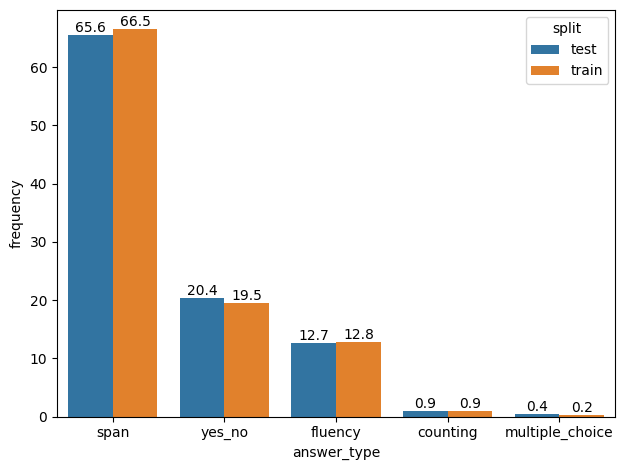

In [ ]:
plot_answer_type_distribution(qa_dataset)

In [ ]:
for answer_type in AnswerType.list(return_unknown=False):
    example = qa_dataset[qa_dataset["answer_type"] == answer_type].sample(3)
    print(answer_type)
    print()
    print_readable_questions(example)
    print("=" * 100)

span

id: 3yhh42uu5bfa2irondg2nax6np10lw
Q		Who was running around? || span
A		Fido. || Fido was running around

id: 3r5f3lqfv2kfao0b4z9mlq4m17moz3
Q		what type of dog was Rob? || span
A		partly bloodhound, || It was supposed that Rob was partly bloodhound

id: 3dpnqgw4llf9il6ijax2au5mfap64g
Q		What bridge? || span
A		George Washington Bridge || New York's George Washington Bridge

yes_no

id: 39u1bhvtdlru2nyqf90cbz5ulfbt3u
Q		Are presidents constantly being evaluated by the media? || yes_no
A		yes || Constant scrutiny from the media means the president essentially works inside glass walls

id: 3tayzsbpll8425psm9hhik4gdcjs23
Q		What about species? || yes_no
A		yes || This can refer to genetic variation, ecosystem variation, or species variation (number of species) within an area, biome, or planet

id: 308q0pevb8dq8b7v262io567avq9i5
Q		Do they have a language? || yes_no
A		Yes || The Serbian language is official in Serbia, co

fluency

id: 3p1l2b7ad1pv5zj7pyiddbtollwolb
Q		Where were th

Yes and no answers are almost equally distributed.

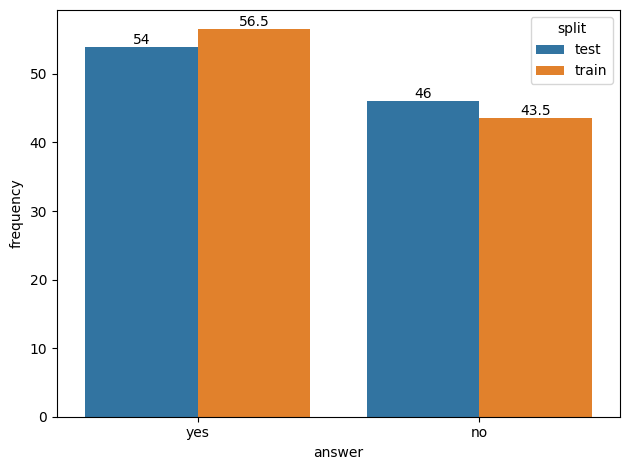

In [ ]:
def plot_yes_no_distribution(qa_dataset: pd.DataFrame):
    yes_no_answers = qa_dataset[qa_dataset["answer_type"] == "yes_no"].copy()
    yes_no_answers["answer"] = yes_no_answers["answer"].apply(normalize_answer)
    plot_distribution(yes_no_answers, field="answer", hue="split")

plot_yes_no_distribution(qa_dataset)

In [ ]:
del qa_dataset

## Remove long answers from training set

In the Data Inspection section we found that long `span` answers are simply wrong. Therefore, we remove it from the training set before going on.

In [ ]:
dataset = datasets.load_from_disk(CONFIG.dataset.filtered_dir)
dataset

DatasetDict({
    train: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story', 'qa_length', 'last_turn'],
        num_rows: 7193
    })
    test: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})

In [ ]:
def remove_long_span_answers(example, max_length):
    questions = []
    answers = []
    for question_item, answer_item in zip(example["questions"],
                                          example["answers"]):
        
        if question_item["answer_type"] == str(AnswerType.SPAN):
            answer = answer_item["input_text"]
            length = len(answer.split())
            if length > max_length:
                continue

        questions.append(question_item)
        answers.append(answer_item)

    qa_length = len(questions)
    return {
        'questions': questions,
        'answers': answers,
        'qa_length': qa_length
    }


print("Removing long span answers...")
dataset["train"] = dataset["train"].map(remove_long_span_answers, fn_kwargs={"max_length": CONFIG.span_max_length})
print("Done!")

filtered_dataset = remove_examples_with_no_qa(dataset)
filtered_dataset.save_to_disk(CONFIG.dataset.filtered_dir)

del dataset
del filtered_dataset

Removing long span answers...


Map:   0%|          | 0/7193 [00:00<?, ? examples/s]

Done!


Filter:   0%|          | 0/7193 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Examples with no qa pairs: {'train': 1, 'test': 0}


,source,name,questions,id,answers,filename,story,qa_length,last_turn
0,gutenberg,data/gutenberg/txt/Edward Phillips Oppenheim__...,[],3i33ic7zwf20293y59vqxkaargp2ae,[],data/gutenberg/txt/Edward Phillips Oppenheim__...,"CHAPTER XXXII \n\n""You are very smart, Ernesti...",0,1



Filtering out examples with no qa pairs...


Filter:   0%|          | 0/7193 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Done!

Number of examples: {'train': 7192, 'test': 500}


Saving the dataset (0/1 shards):   0%|          | 0/7192 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

## Input preparation

In order to train our models, we have to prepare the inputs properly. First of all, we explode the QA pairs so that to have one record for each question. Then, we preprocess the texts. In particular:
1. we fix the rationales by removing leading and trailing non alphanumeric chars, and by restoring truncated words
2. we remove multiple spaces from the texts of our inputs (changing the rationale spans accordingly)
3. we clean the answers by removing leading and trailing non alphanumeric chars

In [ ]:
dataset = datasets.DatasetDict.load_from_disk(CONFIG.dataset.filtered_dir)
train_dataset = dataset["train"].select(range(10))

preprocessing = CoQADatasetPreprocessing()
train_dataset = train_dataset.map(
    batched_function(preprocessing.explode_questions, scalar_output=False),
    batched=True,
    remove_columns=dataset["train"].column_names,
)
train_dataset = train_dataset.rename_column("story", "passage")
train_dataset = train_dataset.remove_columns(["questions", "answers", "qa_length", "last_turn"])
train_dataset = train_dataset.map(
    batched_function(preprocessing.preprocess_texts), batched=True
)

print(train_dataset)
train_dataset[:5]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Dataset({
    features: ['source', 'name', 'id', 'filename', 'passage', 'turn', 'question', 'answer', 'rationale', 'span_start', 'span_end', 'answer_type', 'history', 'history_length'],
    num_rows: 150
})


{'source': ['wikipedia', 'wikipedia', 'wikipedia', 'wikipedia', 'wikipedia'],
 'name': ['Vatican_Library.txt',
  'Vatican_Library.txt',
  'Vatican_Library.txt',
  'Vatican_Library.txt',
  'Vatican_Library.txt'],
 'id': ['3zotghdk5ibi9cex97fepx7jetpso7',
  '3zotghdk5ibi9cex97fepx7jetpso7',
  '3zotghdk5ibi9cex97fepx7jetpso7',
  '3zotghdk5ibi9cex97fepx7jetpso7',
  '3zotghdk5ibi9cex97fepx7jetpso7'],
 'filename': ['Vatican_Library.txt',
  'Vatican_Library.txt',
  'Vatican_Library.txt',
  'Vatican_Library.txt',
  'Vatican_Library.txt'],
 'passage': ['The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475 , although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabul

### No History

Given a passage $P$ and a question $Q$, the corresponding input will be obtained by concatenating $P$ to $Q$ separated by a model-dependant separator.
- DistilRoBERTa input: `<s>Q</s></s>P</s><pad>...<pad>`
- BERTTiny input: `[CLS] Q [SEP] P [SEP] [PAD] ... [PAD]`

Here, we have to address two problems:
- the input may exceed the `max_sequence_length` of the model (i.e. 512 tokens). In such case, we truncate only the passage $P$.
- if we want to use the rationale, we need to map the rational span chars indices to the corresponding tokens indices.

Truncating the passage leads to another problem: the rationale (hence, the answer) may not be contained in the truncated passage. A way to handle such problem is by considering several "windows" of the passage for each QA pair.

In [ ]:
def process_data_to_model_inputs(tokenizer, data, add_history=False):
    preprocessing = CoQADatasetPreprocessing(tokenizer,
                                             use_window=True,
                                             encoder_max_length=300)
    return preprocessing.process_data_to_model_inputs(data,
                                                      add_history=add_history)


def prepare_and_show_inputs(checkpoint, data, add_history=False):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    inputs = process_data_to_model_inputs(tokenizer,
                                          data,
                                          add_history=add_history)
    show_inputs(tokenizer, data, inputs)

In [ ]:
indices = np.random.choice(train_dataset.num_rows, size=3)
target = train_dataset.select(indices)[:]

for checkpoint_name, checkpoint in CONFIG.checkpoints.__dict__.items():
    print("Input examples for:", checkpoint_name)
    print()
    prepare_and_show_inputs(checkpoint, target)
    print("=" * 30)

Input examples for: distil_roberta

input_ids                  : [[0, 12196, 16, 5, 5560, 13, 116, 2, 2, 133, 11484, 40201, 12589, 5672, 49038, 55, 10266, 373, 5, 11484, 5672, 50, 1622, 5, 468, 415, 6, 16, 5, 5560, 9, 5, 8427, 4250, 6, 2034, 11, 11484, 412, 4, 8575, 2368, 2885, 11, 501, 2545, 6, 1712, 24, 16, 203, 2530, 6, 24, 16, 65, 9, 5, 7763, 18146, 11, 5, 232, 8, 6308, 65, 9, 5, 144, 1233, 12245, 9, 4566, 14301, 4, 85, 34, 3337, 6, 151, 20993, 6355, 31, 1328, 750, 6, 25, 157, 25, 112, 4, 134, 153, 11118, 2799, 6, 61, 680, 103, 290, 6, 1497, 5853, 879, 873, 5571, 4, 20, 11484, 5672, 16, 10, 557, 5560, 13, 750, 6, 488, 6, 10561, 6, 2866, 8, 37007, 4, 20, 11484, 5672, 16, 490, 7, 1268, 54, 64, 3780, 49, 18952, 8, 557, 782, 4, 23769, 1975, 1517, 918, 13, 940, 892, 9, 6052, 31, 2799, 1027, 227, 504, 2663, 8, 4525, 64, 28, 5372, 11, 621, 50, 30, 7107, 4, 96, 494, 777, 6, 5, 11484, 5672, 880, 41, 2557, 237, 12, 180, 695, 9, 16808, 3009, 63, 2783, 9, 42486, 6, 7, 28, 156, 577, 804, 4, 20,

### History

Given a passage $P$, a question $Q_i$ and an history $H=\{(Q_j, A_j)\}_{j=1..i-1}$, the corresponding input will be obtained as the concatenation of $H$, $Q$ and $P$ separated by a model-dependant separator, as follows:
- DistilRoBERTa input: `<s>Q1</s>A1</s>...Qi-1</s>Ai-1</s>Qi</s></s></s>P</s><pad>...<pad>`
- BERTTiny input: `[CLS] Q1 [SEP] A1 [SEP] ... Qi-1 [SEP] Ai-1 [SEP] Qi [SEP] P [SEP] [PAD] ... [PAD]`

By adding the history, the input very often exceed the `max_sequence_length` of the model (i.e. 512 tokens). From the analysis above, we know that each QA pair requires around 10 tokens. Hence, an history of $[3..5]$ passes is a good trade-off between the context and the needed space.

In [ ]:
indices = np.random.choice(train_dataset.num_rows, size=3)
target = train_dataset.select(indices)[:]
for checkpoint_name, checkpoint in CONFIG.checkpoints.__dict__.items():
    print("Input examples for:", checkpoint_name)
    print()
    prepare_and_show_inputs(checkpoint, target, add_history=True)
    print("=" * 30)

Input examples for: distil_roberta

input_ids                  : [[0, 2264, 16, 5, 589, 184, 7, 116, 2, 29972, 9, 1568, 977, 2, 6209, 14, 10, 650, 1228, 116, 2, 3084, 6, 24, 16, 5, 1154, 2737, 1228, 11, 5, 315, 532, 2, 2264, 40, 28, 2121, 11, 2760, 116, 2, 627, 4282, 1284, 10893, 824, 2, 8569, 40, 14, 28, 116, 2, 243, 40, 28, 15740, 23, 5, 2737, 2, 2264, 40, 28, 89, 116, 2, 2, 133, 589, 9, 1568, 36, 791, 21897, 6, 1568, 6, 50, 121, 9, 230, 43, 16, 10, 940, 557, 2737, 11, 1568, 4, 20, 2737, 6, 2885, 11, 37708, 6, 10726, 9, 20, 1821, 6, 1337, 5318, 1767, 6, 3222, 32231, 11429, 5798, 88, 237, 5286, 557, 9696, 8, 707, 2038, 1304, 4, 10261, 5, 5444, 8, 17874, 6, 1568, 16, 67, 157, 684, 13, 63, 2038, 1304, 6, 61, 680, 5, 221, 25656, 5029, 835, 9, 8029, 6, 5, 589, 9, 1568, 21636, 835, 9, 2090, 6, 5, 2589, 835, 6, 5, 835, 9, 3574, 1841, 4237, 6, 5, 3740, 835, 9, 1909, 6275, 9307, 6, 5, 4572, 835, 9, 28640, 7612, 8, 12221, 9307, 8, 5, 46013, 835, 4, 20, 2737, 855, 16914, 29, 2219, 195, 6, 151, 

In [ ]:
del dataset
del train_dataset
del target

# [Task 2] Train, test and validation split

In [ ]:
dataset = datasets.load_from_disk(CONFIG.dataset.filtered_dir)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story', 'qa_length', 'last_turn'],
        num_rows: 7192
    })
    test: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


In [ ]:
train_data = dataset["train"]
test_data = dataset["test"]
splitted_dataset = train_data.train_test_split(train_size=0.8, seed=42)
splitted_dataset["validation"] = splitted_dataset.pop("test")
splitted_dataset["test"] = test_data

print(splitted_dataset)

splitted_dataset.save_to_disk(CONFIG.dataset.splitted_dir)
del train_data
del test_data

DatasetDict({
    train: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story', 'qa_length', 'last_turn'],
        num_rows: 5753
    })
    validation: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story', 'qa_length', 'last_turn'],
        num_rows: 1439
    })
    test: Dataset({
        features: ['source', 'name', 'questions', 'id', 'answers', 'filename', 'story', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/5753 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1439 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Before proceeding with the next task, we explode the questions and apply the preprocessing as discussed in the Input Preparation section of the first task.

In [ ]:
preprocessing = CoQADatasetPreprocessing(**CONFIG.preprocessing.__dict__)
dataset = splitted_dataset.map(batched_function(preprocessing.explode_questions, scalar_output=False), batched=True)
dataset = dataset.rename_column("story", "passage")
dataset = dataset.remove_columns(["questions", "answers", "qa_length", "last_turn"])
dataset = dataset.map(batched_function(preprocessing.preprocess_texts), batched=True)

dataset.save_to_disk(CONFIG.dataset.processed_dir)

print(dataset)
dataset["train"][:5]

Map:   0%|          | 0/5753 [00:00<?, ? examples/s]

Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/85827 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/7918 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/85827 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21441 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7918 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['source', 'name', 'id', 'filename', 'passage', 'turn', 'question', 'answer', 'rationale', 'span_start', 'span_end', 'answer_type', 'history', 'history_length'],
        num_rows: 85827
    })
    validation: Dataset({
        features: ['source', 'name', 'id', 'filename', 'passage', 'turn', 'question', 'answer', 'rationale', 'span_start', 'span_end', 'answer_type', 'history', 'history_length'],
        num_rows: 21441
    })
    test: Dataset({
        features: ['source', 'name', 'id', 'filename', 'passage', 'turn', 'question', 'answer', 'rationale', 'span_start', 'span_end', 'answer_type', 'history', 'history_length'],
        num_rows: 7918
    })
})


{'source': ['race', 'race', 'race', 'race', 'race'],
 'name': ['high12374.txt',
  'high12374.txt',
  'high12374.txt',
  'high12374.txt',
  'high12374.txt'],
 'id': ['3tvrfo09gkfiz8xzqp59wokhyurlxe',
  '3tvrfo09gkfiz8xzqp59wokhyurlxe',
  '3tvrfo09gkfiz8xzqp59wokhyurlxe',
  '3tvrfo09gkfiz8xzqp59wokhyurlxe',
  '3tvrfo09gkfiz8xzqp59wokhyurlxe'],
 'filename': ['high12374.txt',
  'high12374.txt',
  'high12374.txt',
  'high12374.txt',
  'high12374.txt'],
 'passage': ['To get to the tennis court, Conner Stroud has to push his wheelchair there. The 15-yea-old from North Carolina, US was born without legs. But when he picks up his racquet and begins to hit a ball, you quickly see that the young man just want to win. Stroud began playing tennis at age 5 at the small tennis club his parents own. For years, he played against able-bodied players by putting rubber on the stumps of his legs. Though he was a foot (30.48cm) or two shorter than many of the players he played against, he won a number of ma

The different types of answer are equally distributed across the three splits.

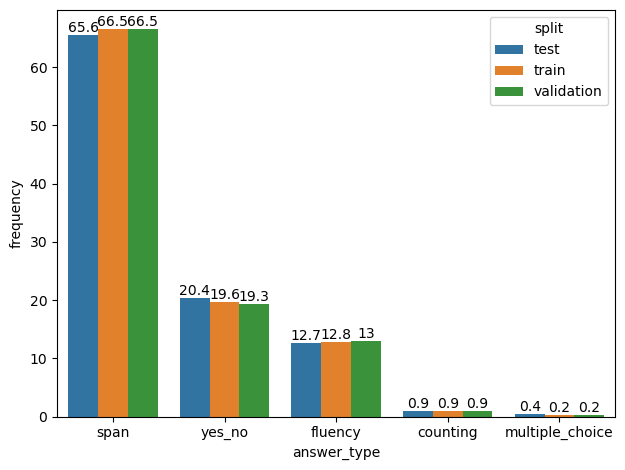

In [ ]:
qa_dataset = create_dataframe(dataset)
plot_answer_type_distribution(qa_dataset)

In [ ]:
del qa_dataset
del splitted_dataset
del dataset

NameError: name 'qa_dataset' is not defined

# [Task 3] Model definition

We use an hybrid approach, i.e. both extractive and generative. We use an encoder-decoder model, where the encoder also predicts if the answer is yes/no/generative and the probability that each token is in the rationale. The last hidden state of the passage are multiplied by this probability before being passed to the decoder model.

**Attention:** The following code is just a copy and paste from the file **src/models.py** for visualization purpose. All models implementation and working class could be founded there.

# [TASK 4] Question generation with text passage $P$, question $Q$

We want to define $f_\theta(P, Q)$: consider a dialogue on text passage $P$. For each question $Q_i$ at dialogue turn $i$, we want $f_\theta(P, Q_i) \approx A_i$.

- Our question-answering model requires two inputs: the passage $P$ and the question $Q_i$.
- The model generates the answer $A_i$.

As discussed in [Task 1], given a passage $P$ and a question $Q$, the corresponding input will be obtained by concatenating $P$ to $Q$ separated by a model-dependant separator.
- DistilRoBERTa input: `<s>Question</s></s>Passage</s><pad>...<pad>`
- BERTTiny input: `[CLS] Question [SEP] Passage [SEP] [PAD] ... [PAD]`

**Attention:** The following code is just a copy and paste from the file **src/evaluation.py** for visualization purpose. All models implementation and working class could be founded there.

# [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

We want to define $f_\theta(P, Q, H)$: consider a dialogue on text passage $P$. For each question $Q_i$ at dialogue turn $i$ and the corresponding dialogue history $H_i = \{ Q_0, A_0, \dots, Q_{i-1}, A_{i-1} \}$, we want $f_\theta(P, Q_i, H_i) \approx A_i$.

- Our question-answering model requires three inputs: the passage $P$, the question $Q_i$ and, the history $H_i$.
- The model generates the answer $A_i$.

To facilitate easy access to these inputs and outputs, we need to prepare our inputs properly. As discussed in [Task 1], truncating the history from the end seems reasonable. Hence given a passage $P$, a question $Q$ and an history $H=\{ Q_{i-k}, A_{i-k}, \dots, Q_{i-1}, A_{i-1} \}$ at turn $i$, the corresponding input will be obtained as the concatenation of $H$, $Q$ and $P$ separated by a model-dependant separator, as follows:
- DistilRoBERTa input: `<s>Qi-k</s>Ai-k</s>...Qi-1</s>Ai-1</s>Qi</s></s></s>P</s><pad>...<pad>`
- BERTTiny input: `[CLS] Qi-k [SEP] Ai-k [SEP] ... Qi-1 [SEP] Ai-1 [SEP] Qi [SEP] P [SEP] [PAD] ... [PAD]`

We choose $k=4$.

# [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

First of all, we have to process data to get inputs for the two models. Here, we have to understand how to handle questions whose number of tokens does not fit in the two models (i.e. number of tokens > 512), in the training phase.
We have two options:
- truncate the passage and discard the question if the rationale is not contained in the input. If the rationale is not in the passage, the question is likely to be unanswerable.
- take multiple windows of the same passage and sample the ones which contain the rationale.

The first approach is far easier and seems to be reasonable given that we have to discard very few questions.

## Create train dataset

In [ ]:
for checkpoint_name, checkpoint in CONFIG.checkpoints.__dict__.items():
    print("Processing data for:", checkpoint_name)
    dataset = datasets.load_from_disk(CONFIG.dataset.processed_dir)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    preprocessing = CoQADatasetPreprocessing(tokenizer, **CONFIG.preprocessing.__dict__)
    dataset = dataset.map(
        preprocessing.process_data_to_model_inputs,
        fn_kwargs={"add_history": False},
        batched=True,
        remove_columns=dataset["train"].column_names,
        num_proc=None,
    )
    num_rows = dataset["train"].num_rows
    print("Number of rows in the training set before removing potentially unanswerable questions:", num_rows)
    dataset["train"] = dataset["train"].filter(lambda example: np.asarray(example["rationale_start"]) != -1, batched=True)
    print("Number of rows in the training set after removing potentially unanswerable questions:", dataset["train"].num_rows)
    removed_rows = num_rows - dataset["train"].num_rows
    removed_ratio = removed_rows / num_rows
    print(f"Removed rows: {removed_rows} ({removed_ratio:.2%})")
    dataset.save_to_disk(CONFIG.dataset.train_no_history(checkpoint_name))
dataset

## Train

In [ ]:
hyperparameters = PropertyDict(
    seed=42,
    checkpoint_name="bert_tiny",
    model_name="bert_tiny",
    model_type="encoder_decoder",
    initialize_cross_attention=True,
    yng_loss_weight=0.6,
    rationale_loss_weight=0.8,
    generative_loss_weight=0.2,
    batch_size=32,
    val_batch_size=64,
    generate_batch_size=32,
    num_workers=2,
    num_epochs=3,
    history_length=4,
    optimizer_name="AdamW",
    learning_rate=2e-4,
    scheduler="linear",
    warmup_fraction=0.1,
    teacher_force_scheduler="linear",
    tf_start = 1.,
    tf_end = 0.,
    tf_fraction = 0.6,
    accumulation_steps=1,
    gradient_clip=1.0,
    mixed_precision="fp16",
    checkpoint_interval=700,
    log_interval=700,
    cpu=False,
)

with wandb.init(project=CONFIG.wandbConfig.project, config=hyperparameters):
    config = wandb.config

    set_seed(config.seed)

    # Make the model
    tokenizer = make_tokenizer(config)
    model = make_model(config, tokenizer)

    # Make the data
    train_data = get_data("train", config)
    val_data = get_data("validation", config)
    train_dataloader = make_dataloader(train_data, tokenizer, config, split="train")
    val_dataloader = make_dataloader(val_data, tokenizer, config, split="validation")

    # Make the loss, the optimizer and the scheduler
    loss_fn = make_loss(config)
    optimizer = make_optimizer(model, loss_fn, config)
    scheduler = make_scheduler(
        optimizer, steps_per_epoch=len(train_dataloader), config=config
    )
    tf_scheduler = make_teacher_force_scheduler(steps_per_epoch=len(train_dataloader), config=config)

    # model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, metrics = make(config)
    print(model)

    train(
        model,
        train_dataloader,
        val_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        config,
        teacher_force_scheduler=tf_scheduler,
    )
    hist = "hist" if config.history_length>0 else "nohist"
    
    torch.save(model.state_dict(), f"checkpoints/{config.checkpoint_name}_{config.seed}_{hist}.pt")

## Evaluation

In [4]:
val_config =  {
  "checkpoint_name": "bert_tiny",
  "model_type": "encoder_decoder",
  "initialize_cross_attention": True,
  "batch_size": 256
}

In [9]:
# train_data = datasets.load_from_disk("data/processed//train/")
val_data = datasets.load_from_disk("data/processed/validation/").select(range(1024))
test_data = datasets.load_from_disk("data/processed/test/").select(range(1024))

tokenizer = make_tokenizer(val_config)
model = make_model(val_config, tokenizer)
model.load_state_dict(torch.load("checkpoints/bert_tiny.pt"))

results = evaluate(model, tokenizer, val_data, test_data, val_config)

print()
for key, (data, res)in results.items():
    print(f"\033[1mEvaluating {key} set: \033[0m\n")

    print("Example of Q&A generated:")
    for i in range(5):
        print("Q:", data["question"][i])
        print("A_pred:", data["pred_answer"][i])
        print("A_true:", data["answer"][i])
        print()

    tot_squad_f1 = res.pop("tot_squad_f1")

    print(f"Total {key} dataset SQUAD-f1: {tot_squad_f1[0]:.2f}")

    for k,v in res.items():
        print(f" - {k} = {v[0]:.2f} ({v[1]:.1%} %)")

    print("_"*30)
    print()

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Cross-attention has been initialized with self-attention weights.
Evaluation of  val set...
Evaluation of  test set...

Evaluating val set: 

Example of Q&A generated:
Q: How long did it take to win?
A_pred: ten minutes
A_true: twenty-eight minutes

Q: How old was the winner?
A_pred: ten
A_true: ten

Q: What's his name?
A_pred: david
A_true: David Prang

Q: What year did David beat him?
A_pred: 1977
A_true: 1975

Q: What did Watson play between moves?
A_pred: chess
A_true: nothing

Total val dataset SQUAD-f1: 0.23
 - yes_ans_f1 = 0.66 (10.7% %)
 - no_ans_f1 = 0.43 (8.3% %)
 - mc_quest_f1 = 0.24 (0.8% %)
 - wh_quest_f1 = 0.15 (73.1% %)
______________________________

Evaluating test set: 

Example of Q&A generated:
Q: What color was Cotton?
A_pred: white
A_true: white

Q: Where did she live?
A_pred: a farm
A_true: in a barn

Q: Did she live alone?
A_pred: no
A_true: no

Q: Who did she live with?
A_pred: cotton
A_true: with her mommy and 5 sisters

Q: What color were her sisters?
A_pred:

# [Task 7] Error Analysis

In [10]:
df_test = datasets.load_from_disk("data/splitted/validation/").select(range(100)).with_format("pandas")[:]

for source, df in df_test.groupby(by=['source']):

    conversations_results = pd.DataFrame(evaluate_conversation(model, tokenizer, df))
    conversations_results = conversations_results.sort_values(by='conversation_f1_score', ascending=True, inplace=False).iloc[:5, :].reset_index(drop=True)

    print_source_name(source[0])
    for i in range(len(conversations_results)):
        print_conversation(conversations_results["passage"][i][:200]+"[...]", conversations_results["questions"][i], conversations_results["answers"][i],
                            conversations_results["predicted_answers"][i], conversations_results["answers_f1_scores"][i],
                            conversations_results["conversation_f1_score"][i])

  0%|          | 0/23 [00:00<?, ?it/s]



####################################################################################################
############################################### CNN ################################################
####################################################################################################

Passage: (CNN)The passing of Saudi Arabia's King Abdullah Bin Abdul-Aziz may not have come as a surprise -- his health had deteriorated in recent years -- but until the very end, the monarch was determined to [...]
Question: what did Abdullan possess?
Predicted Answer: military awareness
Answer: political acumen
Answer SQUAD-f1: 0.0

Question: what did he need this for?
Predicted Answer: power
Answer: to adjust to the changing needs and increased political awareness of the Saudi populac
Answer SQUAD-f1: 0.0

Question: was his death a surprise?
Predicted Answer: yes
Answer: no
Answer SQUAD-f1: 0.0

Question: why not?
Predicted Answer: it was due to the financial issues
Answer: his healt



####################################################################################################
############################################ GUTENBERG #############################################
####################################################################################################

Passage: CHAPTER XLV. 

ALL'S WELL THAT ENDS WELL. 





Granville helped him on his arm into the judge's room amid profound silence. All the court was deeply stirred. A few personal friends hurried after him [...]
Question: Who is the main person in this story?
Predicted Answer: sir gilbert
Answer: Granville
Answer SQUAD-f1: 0.0

Conversation SQUAD-f1: 0.0

Passage: CHAPTER XV. SAFE-CONDUCT 

Across the body of that convulsively sobbing woman, the mother of one and the mistress of the other, the eyes of those mortal enemies met, invested with a startled, appalled[...]
Question: Why was the woman crying?
Predicted Answer: she was shocked
Answer: two mortal enemies met,
Answer SQUAD-f1:



####################################################################################################
############################################## MCTEST ##############################################
####################################################################################################

Passage: Once upon a time there was a little elf named Boo. Boo longed for a goldfish more than anything in the world, so he begged and begged his parents for one. Finally, his parents told him that he could h[...]
Question: What was the elf's name?
Predicted Answer: booz
Answer: Boo
Answer SQUAD-f1: 0.0

Question: What size was he?
Predicted Answer: blackfish
Answer: little
Answer SQUAD-f1: 0.0

Question: What did he ask his parents for?
Predicted Answer: fish
Answer: his parents
Answer SQUAD-f1: 0.0

Question: Where did he look first?
Predicted Answer: a goldfish
Answer: under his pillow
Answer SQUAD-f1: 0.0

Question: Did he find one there?
Predicted Answer: yes
Answer: No
Answer SQ



####################################################################################################
############################################### RACE ###############################################
####################################################################################################

Passage: "Show them the money!" That's what some people are saying for college athletes. They say students who play sports for their school should receive salaries. 

Top athletes should be paid because many o[...]
Question: Who do people think should get paid?
Predicted Answer: students
Answer: ollege athletes
Answer SQUAD-f1: 0.0

Question: What do they think they should receive?
Predicted Answer: soccer player
Answer: salaries
Answer SQUAD-f1: 0.0

Question: Why?
Predicted Answer: because they are good stadiums
Answer: because many of them practice full time
Answer SQUAD-f1: 0.16666666666666666

Question: Can they be employed?
Predicted Answer: yes
Answer: No
Answer SQUAD-f1: 0.0

Q



####################################################################################################
############################################ WIKIPEDIA #############################################
####################################################################################################

Passage: Sarajevo is the capital and largest city of Bosnia and Herzegovina, with a population of 275,524 in its current administrative limits. The Sarajevo metropolitan area, including Sarajevo Canton and Eas[...]
Question: What is the Capital of Bosnia and Herzegovina?
Predicted Answer: bosnia
Answer: Sarajevo
Answer SQUAD-f1: 0.0

Question: What is the populaion?
Predicted Answer: bosnia
Answer: 275,524
Answer SQUAD-f1: 0.0

Question: What is a nickname of Sarajevo?
Predicted Answer: bosnian war
Answer: Jerusalem of Europe
Answer SQUAD-f1: 0.0

Question: What else?
Predicted Answer: serbian church
Answer: Jerusalem of the Balkans
Answer SQUAD-f1: 0.0

Question: When did the modern d